# Research on the telecom operator Interconnect 


# Description of the Project

The telecom operator Interconnect would like to be able to forecast their churn of clients.

If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. 
Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

We need to predict whether a customer will leave the Telecom company soon using the
data on clients’ past behavior and termination of contracts.

Building a model with the maximum possible AUC-ROC score.
Additionally, we will measure the accuracy metric and compare it with the AUC-ROC.

# The main steps of the analysis
* [Step 1](#section1). Download and prepare the data
* [Step 2](#section2). Train the model without taking into account the imbalance
* [Step 3](#section3). Taking into account the imbalance of classes using Class weight adjustment
* [Step 4](#section4). Sanity check for the model
* [Step 5](#section5). Overall conclusion

<a id='section1'></a>
## Download and prepare the data
### Open the data file and study the general information

In [1]:
# general
import pandas as pd
import numpy as np
import re
import time

# visualization tools
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV

# scores
from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, roc_auc_score, roc_curve, confusion_matrix, average_precision_score

In [2]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [3]:
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', sep=',')
except:
    df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv', sep=',')

* getting the info for the data dictionary:

In [4]:
# function to describe the data on one dataframe
def get_df_info(df):
    print('getting the info for the dataframe:')
    df.info();
    print()
    print('Here are the first and the last 20 rows to get some idea about the data:')
    with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
        display(df.head(20))
        display(df.tail(20))
        display('The description of the data gives us a good information about the colums like min and max values:')
        display(df.describe(include='all'))
    
    print ('Duplicate entries in the table:', df.duplicated().sum())

get_df_info(df)
print()

getting the info for the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperl

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7023,1035-IPQPU,Female,1,Yes,No,63,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,103.50,6479.4,No
7024,7398-LXGYX,Male,0,Yes,No,44,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),84.80,3626.35,No
7025,2823-LKABH,Female,0,No,No,18,Yes,Yes,Fiber optic,No,No,Yes,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,No
7026,8775-CEBBJ,Female,0,No,No,9,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Yes
7027,0550-DCXLH,Male,0,No,No,13,Yes,No,DSL,No,Yes,No,Yes,Yes,Yes,Month-to-month,No,Mailed check,73.35,931.55,No
7028,9281-CEDRU,Female,0,Yes,No,68,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),64.10,4326.25,No
7029,2235-DWLJU,Female,1,No,No,6,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.40,263.05,No
7030,0871-OPBXW,Female,0,No,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.05,39.25,No
7031,3605-JISKB,Male,1,Yes,No,55,Yes,Yes,DSL,Yes,Yes,No,No,No,No,One year,No,Credit card (automatic),60.00,3316.1,No
7032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.75,75.75,Yes


'The description of the data gives us a good information about the colums like min and max values:'

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


Duplicate entries in the table: 0



* There are no missing data or duplicated data.
* The primary key is the customer id which is unique.
* The table has 21 columns and has 7043 customers.
    * `gender` Female/Male values should be converted into 0/1 values.
    * `SeniorCitizen` has a very low part of 1 values as reasonable statistic population, maybe those observations should be dropped but this should be checked after the model training when we will have the importancy of this feature.
    * `Partner` and `Dependents` No/Yes values should be converted into 0/1 values.
    * `tenure` has numerical values between 0 and 72.
    * `Contract`, `PaymentMethod` should be encoded into numeric column, hope to ordinal encoding possibility.
    * `PaperlessBilling` No/Yes values should be converted into 0/1 values. 
    * `TotalCharges` should be converted to float type as `MonthlyCharges` does.    
    * `InternetService` should be encoded into numeric column, hope to ordinal encoding possibility.
    * more than half of the customers with internet service has Fiber optic.
    * about half of the customers have multiple lines service. this parameter can be interesting as well.
    * All the rest of the columns have No/Yes values that should be converted into 0/1 values ('No phone service' or 'No internet service' are equal to No as we have this indication on the `PhoneService` or on `InternetService` with No value I will validate it next)

* checking the number of the unique values in each column, the top value and the frequency for balance check:

In [5]:
with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
    display(df.describe(include='object'))

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Fixing data types

* taking care of all the columns with No/Yes values and convert them into 0/1 values with integer type:

In [7]:
for col in ('Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'MultipleLines', 'PaperlessBilling', 'Churn'):
    df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)
    print(df[col].value_counts())
    df[col] = df[col].astype('int32')

0    3641
1    3402
Name: Partner, dtype: int64
0    4933
1    2110
Name: Dependents, dtype: int64
1    6361
0     682
Name: PhoneService, dtype: int64
0    5024
1    2019
Name: OnlineSecurity, dtype: int64
0    4614
1    2429
Name: OnlineBackup, dtype: int64
0    4621
1    2422
Name: DeviceProtection, dtype: int64
0    4999
1    2044
Name: TechSupport, dtype: int64
0    4336
1    2707
Name: StreamingTV, dtype: int64
0    4311
1    2732
Name: StreamingMovies, dtype: int64
0    4072
1    2971
Name: MultipleLines, dtype: int64
1    4171
0    2872
Name: PaperlessBilling, dtype: int64
0    5174
1    1869
Name: Churn, dtype: int64


* `gender` Female/Male values converted into 0/1 values:

In [8]:
df.loc[df['gender']=='Male','gender']=1
df.loc[df['gender']=='Female','gender']=0
df['gender']=df['gender'].astype('int32')

* 11 observation were dropped because they seem to be errors where the total chages had value of space instead of a number:

In [9]:
df.loc[df['TotalCharges']==' ','TotalCharges']=np.nan
df = df.dropna()

In [10]:
df['TotalCharges']=df['TotalCharges'].astype('float64')
print(df['TotalCharges'].describe())

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


* The total charges has a right tale distribution as we can see the mean 2283 is impacted from the high values and highher than the median 1397.

* Replace the column names (make them lowercase):

In [11]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   gender            7032 non-null   int32  
 2   seniorcitizen     7032 non-null   int64  
 3   partner           7032 non-null   int32  
 4   dependents        7032 non-null   int32  
 5   tenure            7032 non-null   int64  
 6   phoneservice      7032 non-null   int32  
 7   multiplelines     7032 non-null   int32  
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   int32  
 10  onlinebackup      7032 non-null   int32  
 11  deviceprotection  7032 non-null   int32  
 12  techsupport       7032 non-null   int32  
 13  streamingtv       7032 non-null   int32  
 14  streamingmovies   7032 non-null   int32  
 15  contract          7032 non-null   object 
 16  paperlessbilling  7032 non-null   int32  


* in order to simplify the code its better to have the column names in lower case.

### Adding more features

* Now lets plot the contract age for the exited customers and the staying customers:

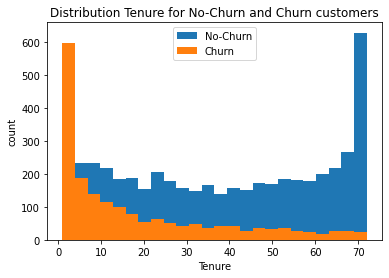

In [12]:
plt.hist(x=df.query('churn==0')['tenure'],bins=24,label='No-Churn')
plt.hist(x=df.query('churn==1')['tenure'],bins=24,label='Churn')
plt.legend()
plt.title("Distribution Tenure for No-Churn and Churn customers")
plt.xlabel('Tenure')
plt.ylabel('count');

On the plot above you can find the distribution of the contract age for the customer who didnt exited on the blue color and for those who left on the orange bars. The conclusions we can get from this graph can be a huge help: it shows us that most of the leaving customers do this in their first months and while the contract age goes up the customers are more loyal and most of them have old contract of 70 months.

* It looks like there are new customers that leave in a rush on the first months, its probably depends on the contract type which should be check in the next section.

In [13]:
df.monthlycharges.describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: monthlycharges, dtype: float64

* nothing to do with monthlycharges column has like a normal distribution by the mean (65) and median (70) values that are closed.

check the other columns for the features which are still in object type:

In [14]:
df.info() # change type to contract type with 0 1 2 also for paymentmethod and internetservice
print(df.contract.value_counts(normalize=True))
print(df.paymentmethod.value_counts(normalize=True))
df.internetservice.value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   gender            7032 non-null   int32  
 2   seniorcitizen     7032 non-null   int64  
 3   partner           7032 non-null   int32  
 4   dependents        7032 non-null   int32  
 5   tenure            7032 non-null   int64  
 6   phoneservice      7032 non-null   int32  
 7   multiplelines     7032 non-null   int32  
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   int32  
 10  onlinebackup      7032 non-null   int32  
 11  deviceprotection  7032 non-null   int32  
 12  techsupport       7032 non-null   int32  
 13  streamingtv       7032 non-null   int32  
 14  streamingmovies   7032 non-null   int32  
 15  contract          7032 non-null   object 
 16  paperlessbilling  7032 non-null   int32  


Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: internetservice, dtype: float64

* changing the contract type to ordinal encoding where the `month-to-month` count as 0 commitment, 1 as 1 year commitment and 2 as 2 years commitment:

In [15]:
df['contract_type'] = df.contract.apply(lambda x: 0 if "Month-to-month" in x else 1 if "One year" in x else 2)

In [16]:
print(df.contract.value_counts())

Month-to-month    3875
Two year          1685
One year          1472
Name: contract, dtype: int64


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   gender            7032 non-null   int32  
 2   seniorcitizen     7032 non-null   int64  
 3   partner           7032 non-null   int32  
 4   dependents        7032 non-null   int32  
 5   tenure            7032 non-null   int64  
 6   phoneservice      7032 non-null   int32  
 7   multiplelines     7032 non-null   int32  
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   int32  
 10  onlinebackup      7032 non-null   int32  
 11  deviceprotection  7032 non-null   int32  
 12  techsupport       7032 non-null   int32  
 13  streamingtv       7032 non-null   int32  
 14  streamingmovies   7032 non-null   int32  
 15  contract          7032 non-null   object 
 16  paperlessbilling  7032 non-null   int32  


* The payment method can be splited to 2 classes on automatic payment and not automatic payment.

In [18]:
df['autopay'] = df.paymentmethod.apply(lambda x: 0 if "(automatic)" not in x else 1)

In [19]:
print(df.paymentmethod.value_counts())
df.autopay.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: paymentmethod, dtype: int64


0    3969
1    3063
Name: autopay, dtype: int64

* In the encoding section I will take care of all the payment types if needed and the internet service.

### How is the target distributed?

In [20]:
print(df.churn.value_counts(normalize=True))
df.churn.value_counts()

0    0.734215
1    0.265785
Name: churn, dtype: float64


0    5163
1    1869
Name: churn, dtype: int64

In [21]:
fig = px.histogram(df.churn.astype('bool'), labels={'value':'Churn','color':'Internet service'},color=df.internetservice,title='Churn distribution colored with Internet service')
fig.show()


In [22]:
fig = px.histogram(df.churn.astype('bool'), labels={'value':'Churn','color':'Contract type'},color=df.contract,title='Churn distribution colored with Contract type')
fig.show()


On both of the Churn Distribution above we can see the count (y axis) of the Churn on the x axis true and of the Non-Churn on the False bar. both bars are colored, on the first graph its the intrenet service and on the second by the Contract type which you can see in the legend on the top right.

* There are 1869 customers that had existed which is 26.58% of the total customers which leaves us with 73.42% that didn't exit yet. The classes of exited and non-exited are imbalanced, this is reasonable and better for the company that only few customers will exit and here its a huge part..
* We can see that on the Exited class there are more Fiber internet than DSL/No internet, and on the contract type Month-to-month. This is reasonable that uncommitted customers will leave, they dont have 1-2 years contract to hold into.

### EDA

**Univariate EDA:**

Let's look at the distirubtions for each numeric variable in the dataset:

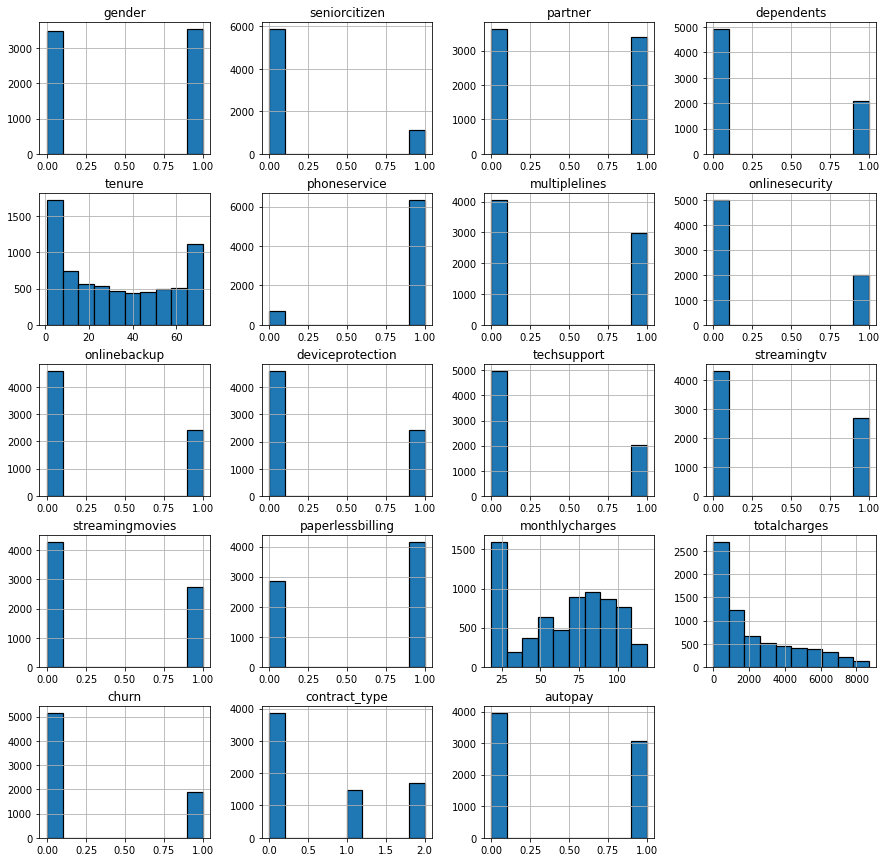

In [23]:
df.hist(edgecolor='black', linewidth=1.2, figsize=(15,15));

* On the graphs above we can find the distribution of each numeric parameter we have:
    * The services columns with the 2 bars (0,1) are imbalanced except `gender` and `partner`
    * We can see it as well on the `tenure` histogram where the left bar is much higher than the others which means that most of the leaving customers just got to the company lately.
    * feature engineering can be also on the features like cont`contract_type` where the 0 commitment is as much as the 2 other of 1-2 years of commitments so maybe to create a feature that say commitment yes or no here, but this should be checked later on after we will have the first scores of the models.

**Bivariate EDA:**

Exploring each features separately with respect to the class it belongs to:

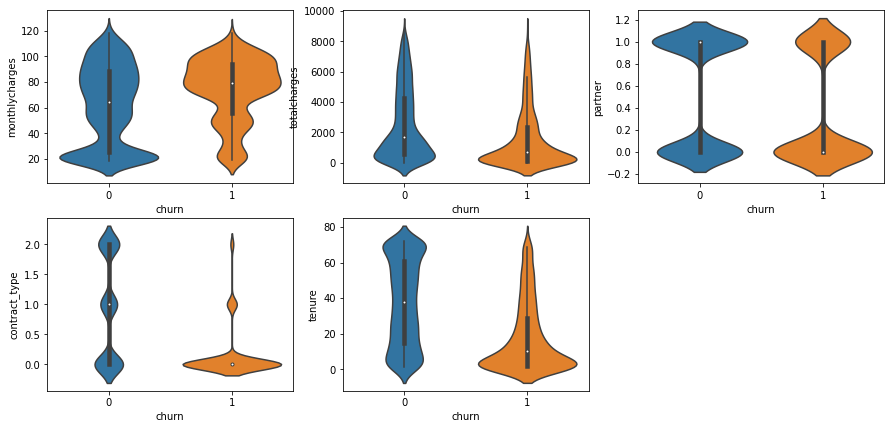

In [24]:
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
sns.violinplot(x='churn', y = 'monthlycharges', data=df)
plt.subplot(2,3,2)
sns.violinplot(x='churn', y = 'totalcharges', data=df)
plt.subplot(2,3,3)
sns.violinplot(x='churn', y = 'partner', data=df)
plt.subplot(2,3,4)
sns.violinplot(x='churn', y = 'contract_type', data=df)
plt.subplot(2,3,5)
sns.violinplot(x='churn', y = 'tenure', data=df);

What we can find in the Violin plots above on all the interesting columns we found before is much more interesting when looking on the differences of exiting (the left blue violin is for the staying customers and the orange on the right is for the customers that exited already):
   * On the `monthlycharges` distribution per churn on the left up corner we can see that the left blue violin of the staying customers with huge peak of amount on the low side ~20 and the churn customers were paying much more, also the white point for the median is higher than the other one.
   * On the other side, on the total charges distribution the exiting customers most of them have very low total because has we can see before they probably didn't stayed much time in order to aggregate large charges in total, also the white point of the median is lower than the one in the blue.
   * In addition on the right up corner we can find the `partner` white point of the median for the churn customers on orange Violin, it means that most of the leaving customer have no partner, and on the left the blue violin for the staying customers the median is on the partner so it means they are more committed.
   * On the right bottom, its the `tenure` distribution which looks much similar to the total charges above it. and we can say by this staying customers that are loyal to the company the total charge didn't increase much as the tenure so they probably have low monthly charges.
   * On the `contract_type` distribution there are 3 values 0,1,2 and we can see nice split for the tree on the staying customers bit on the customers that exited the  huge amount and the median and the all IQR is on the zero commitment.

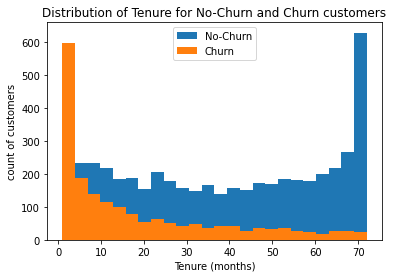

In [25]:
plt.hist(x=df.query('churn==0')['tenure'],bins=24,label='No-Churn')
plt.hist(x=df.query('churn==1')['tenure'],bins=24,label='Churn')
plt.legend()
plt.title("Distribution of Tenure for No-Churn and Churn customers")
plt.xlabel('Tenure (months)')
plt.ylabel('count of customers');

* On the graph above we can see how many customers left or stayed by the time of tenure in months. so we can see that most of the customers that started the contract few years ago stayed (the blue peak on the right) and most of the customers that left, left in the same year (the orange peak on the left).

* If we want to understand the problem of the customers that are exiting on a daily basic or understanding the acute problem that the company has in the first 5 months were most of the new customers left on the same year, how much money those new customers cost to the company for installing the services that they left only few months later.. I believe that a new service had hit the market and had high monthly charges without any commitment from the customer just to sell the service on a fiber internet connection. maybe this new service was not so good for the customers and thats why they were hurry to leave or maybe because of the monthly charges were expensive and a new competition company started because they didn't committed at all it was easy to steal the new customers.

**Let's check how our features correlate with each other and with the target:**

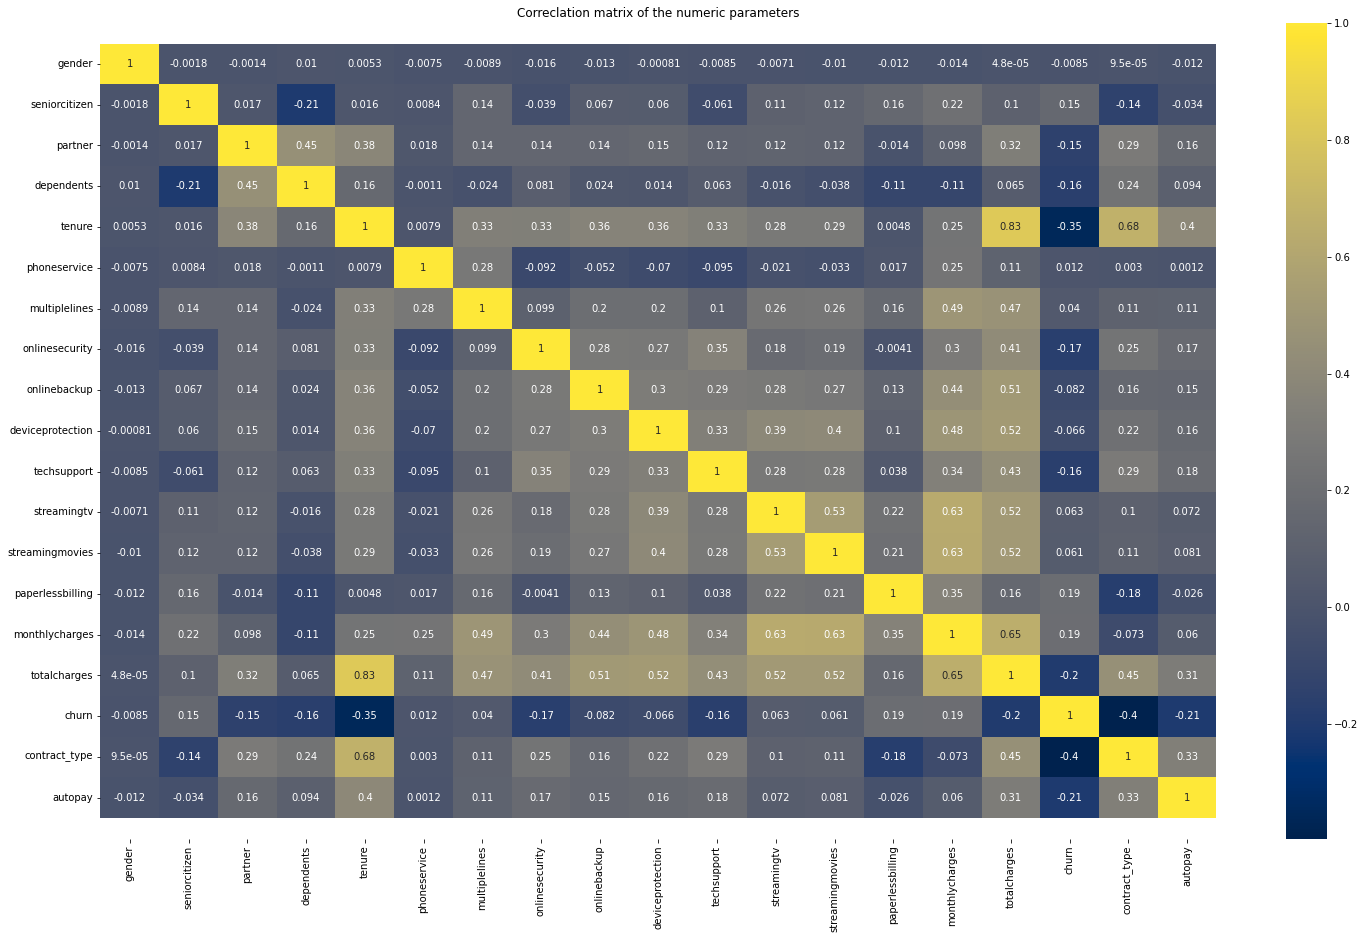

In [26]:
plt.figure(figsize=(25,15))
ax = sns.heatmap(df.corr(), annot=True, cmap='cividis')
plt.title("Correclation matrix of the numeric parameters")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
plt.yticks(rotation=0);

* On the correlation matrix above we can see the correlation between the features and the target (exit):
  * `churn` and `tenure` have a negative correlation of -0.35, which is reasonable if the old customers are loyal so the lower the tenure is the higher the chance for churn in case the customer didn't leave yet. 
  * `totalcharges` and `tenure` has strong positive correlation of 0.83 as long the contract stay on the more total charges got in the company
  * `contract_type` and `tenure` has strong positive correlation of 0.68 as long the contract stay on the more total charges got in the company.
  * there are some more strong positive correlations between the all internet and phone services to the monthlycharges and the totalcharges ao it means those services cost more and make the monthly charge increased and so the total gets increased as well which make sense because also between both of them there is a positive strong correlation.
  * checking the unimportant features that we might find out later which we can see they have no correlation at all like `gender`.

### conclusions

* The merged table has total 21 columns and 7043 customers. there are no missing values and no duplicated in it. all data types were fixed.
* most of the leaving customers do this in their first months and while the tenure goes up the customers are more loyal and most of them have an old contract of 70 months.
* There are 1869 customers that had existed which is 26.58% of the total customers which leaves us with 73.42% that didn't churn yet. The classes of churn and non-churn are imbalanced, this is reasonable and better for the company that only few customers will exit and here its a huge part..
* We can see that on the churn class there are more Fiber internet than DSL/No internet, and on the contract type Month-to-month. This is reasonable that uncommitted customers will leave, they dont have 1-2 years contract to hold into.
* The exiting customers most of them have very low total charges because has we saw before they probably didn't stayed much time in order to aggregate large charges in total.
* The `tenure` distribution which looks much similar to the total charges above it. and we can say by this staying customers that are loyal to the company the total charge didn't increase much as the age so they probably have low monthly charges.
* On the `contract_type` distribution there are 3 values 0,1,2 and we can see nice split for the tree on the staying customers bit on the customers that exited the  huge amount and the median and the all IQR is on the zero commitment.
* `churn` and `tenure` have a negative correlation of -0.35, which is reasonable if the old customers are loyal so the lower the tenure is the higher the chance for churn in case the customer didn't leave yet. 
  * `totalcharges` and `tenure` has strong positive correlation of 0.83 as long the contract stay on the more total charges got in the company
  * `contract_type` and `tenure` has strong positive correlation of 0.68 as long the contract stay on the more total charges got in the company.
  * there are some more strong positive correlations between the all internet and phone services to the monthlycharges and the totalcharges ao it means those services cost more and make the monthly charge increased and so the total gets increased as well which make sense because also between both of them there is a positive strong correlation.
  * checking the unimportant features that we might find out later which we can see they have no correlation at all like `gender`.
  
* new column were added:
  * `contract_type` - 0 for contract of month to month, means no commitment, 1 for 1 year contract and 2 for 2 years contract.
  * `autopay` - The payment method was split to 2 classes on automatic payment and not automatic payment.

<a id='section2'></a>
## Train the model without taking into account the imbalance. 

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   gender            7032 non-null   int32  
 2   seniorcitizen     7032 non-null   int64  
 3   partner           7032 non-null   int32  
 4   dependents        7032 non-null   int32  
 5   tenure            7032 non-null   int64  
 6   phoneservice      7032 non-null   int32  
 7   multiplelines     7032 non-null   int32  
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   int32  
 10  onlinebackup      7032 non-null   int32  
 11  deviceprotection  7032 non-null   int32  
 12  techsupport       7032 non-null   int32  
 13  streamingtv       7032 non-null   int32  
 14  streamingmovies   7032 non-null   int32  
 15  contract          7032 non-null   object 
 16  paperlessbilling  7032 non-null   int32  


First dropping the columns that are not a real feature before the models: 

In [28]:
# dropping the columns that are not a real feature
data=df.drop(['customerid','contract'], axis=1)
with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
    display(data.sample(10))

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,contract_type,autopay
6867,1,0,0,0,67,1,0,No,0,0,0,0,0,0,0,Bank transfer (automatic),19.95,1311.75,0,2,1
97,1,0,0,0,5,1,0,No,0,0,0,0,0,0,0,Mailed check,21.05,113.85,1,0,0
449,1,0,1,1,72,1,0,Fiber optic,1,1,0,1,1,1,0,Bank transfer (automatic),105.50,7611.55,0,2,1
6298,1,0,1,1,46,1,1,Fiber optic,0,1,0,0,0,0,1,Bank transfer (automatic),80.00,3769.70,0,0,1
3966,1,0,1,1,72,1,1,Fiber optic,1,1,0,1,1,1,1,Credit card (automatic),107.70,7919.80,0,2,1
2962,0,0,1,1,3,0,0,DSL,0,0,0,1,0,0,1,Mailed check,31.00,95.05,1,0,0
2164,1,0,1,1,70,1,0,Fiber optic,1,1,1,1,1,0,1,Credit card (automatic),101.10,6994.80,0,2,1
5410,0,0,1,0,64,1,0,Fiber optic,1,0,1,0,1,1,1,Bank transfer (automatic),99.00,6375.80,0,2,1
2646,1,0,0,0,56,1,0,DSL,0,1,1,1,1,1,1,Credit card (automatic),81.80,4534.45,0,2,1
6478,0,0,1,0,60,1,1,Fiber optic,0,1,1,1,1,1,1,Credit card (automatic),110.80,6640.70,0,2,1


### One-Hot Encoding

'paymentmethod','internetservice' columns have only few values 3-4 and can be included in the ohe:

In [29]:
# We will do OHE before Train/Test split for simplicity
ohe_encoding = ['paymentmethod','internetservice']
data_ohe = pd.get_dummies(data[ohe_encoding], drop_first=True)
data_ohe.head(5)

,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,internetservice_Fiber optic,internetservice_No
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,0
4,0,1,0,1,0


In [30]:
# We join back the OHE columns and drop the original ones
data = data.join(data_ohe).drop(ohe_encoding, axis=1)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   int32  
 1   seniorcitizen                          7032 non-null   int64  
 2   partner                                7032 non-null   int32  
 3   dependents                             7032 non-null   int32  
 4   tenure                                 7032 non-null   int64  
 5   phoneservice                           7032 non-null   int32  
 6   multiplelines                          7032 non-null   int32  
 7   onlinesecurity                         7032 non-null   int32  
 8   onlinebackup                           7032 non-null   int32  
 9   deviceprotection                       7032 non-null   int32  
 10  techsupport                            7032 non-null   int32  
 11  stre

In [32]:
features_corr=data.drop(['churn'], axis=1).apply(lambda x: abs(x.corr(df['churn'])))

In [33]:
features_corr.sort_values()

gender                                   0.008545
phoneservice                             0.011691
multiplelines                            0.040033
streamingmovies                          0.060860
streamingtv                              0.063254
deviceprotection                         0.066193
onlinebackup                             0.082307
paymentmethod_Mailed check               0.090773
paymentmethod_Credit card (automatic)    0.134687
partner                                  0.149982
seniorcitizen                            0.150541
dependents                               0.163128
techsupport                              0.164716
onlinesecurity                           0.171270
paperlessbilling                         0.191454
monthlycharges                           0.192858
totalcharges                             0.199484
autopay                                  0.210420
internetservice_No                       0.227578
paymentmethod_Electronic check           0.301455


In [34]:
df_features= pd.DataFrame(features_corr).reset_index()
df_features.columns=['feature','corr']

In [35]:
df_features.query('corr>0.2').sort_values(ascending=False, by='corr')

,feature,corr
16,contract_type,0.396150
4,tenure,0.354049
21,internetservice_Fiber optic,0.307463
19,paymentmethod_Electronic check,0.301455
22,internetservice_No,0.227578
17,autopay,0.210420


* The Top important features by the correlation with the target are:
    * contract_type	                 0.396150
    * tenure	                     0.354049
    * internetservice_Fiber optic	 0.307463
    * paymentmethod_Electronic check 0.301455
    * internetservice_No	         0.227578
    * autopay	                     0.210420

### Split the source data into a training set, a validation set, and a test set

The portion of the data to be assigned to the validation set depends on the number of observations and features, as well as the data variation. Here are the two most common scenarios: 

1) The test set exists (or will exist in the near future), but is unavailable for the time being. The preferable ratio is 3:1. This means 75% for the training set and 25% for the validation set. 

2) The test set doesn't exist. In that case, the source data has to be split into three parts: training, validation, and test. The sizes of the validation set and the test set are usually equal. This scenario gives us a 3:1:1 ratio.

In our case we hit the second common scenario so the data will be split into : 60% for the training set and 20% each for the validation and test sets BUT Im using CV for tuning the hyper parameters so the train and the valid can be into 80% train and the left for 20% test.

In [36]:
# print the number of rows using len()
data_total=len(data)
print('Total Rows:', data_total)

Total Rows: 7032


In [37]:

features_train, features_test, target_train, target_test = train_test_split(
        data.drop('churn', axis=1), data.churn, test_size=0.2, random_state=12345
    )
print('The Train Set total rows for the features and the target:',len(features_train),len(target_train))
print('The Test Set total rows for the features and the target:',len(features_test),len(target_test))

The Train Set total rows for the features and the target: 5625 5625
The Test Set total rows for the features and the target: 1407 1407


*  Using cross check validation for tuning the hyper parameters so the train and the valid can be into 80% train and the left for 20% test, this is 1:4 ratio.
* The dataset of 7032 observations was split to:
  * 80% for the training set - 5625 observations
  * 20% for the test sets -    1407 observations.

In [38]:
features_train.head(5)
# checking the test for the most important features by the correlation with the target
features_test[df_features.query('corr>0.2').feature].head(5)

,tenure,contract_type,autopay,paymentmethod_Electronic check,internetservice_Fiber optic,internetservice_No
3281,49,2,0,1,1,0
1625,9,0,1,0,1,0
4606,11,2,0,0,0,1
5443,26,0,0,1,0,0
2762,25,2,1,0,1,0


### Tuning hyperparameters
* For this classification task, we will develop a model that will predict if the customer will leave the company by the access to behavior data about customers who have already left the company.
* Our target is the `churn` column — tells if the сustomer has left (True - 1, False - 0)
* Our features are all the rest of the columns that are numeric.

The telecom operator Interconnect would like to be able to forecast their churn of clients.

If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their client's personal data, including information about their plans and contracts.

We need to predict whether a customer will leave the Telecom company soon using the data on clients’ past behavior and termination of contracts.

Building a model with the maximum possible AUC-ROC metric and compare it with the accuracy.

Primary metric: AUC-ROC.

Additional metric: Accuracy.

Additional rate: False Negative Rate
* The FN is the important one here, more than the FP:
      * Its better to start a saving process for a customer that the model predict as churn even though he stayed (FP) than missing a customer because the model predicted he would not leave by error (FN). Checking the scores formula how each score depends on minimize FN and maximize TN.

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

$TPR (True Positive Rate) = Recall = Sensitivity = \frac{TP}{TP+FN}$ 

miss rate or false negative rate (FNR):

$FNR = 1 - TPR = \frac{FN}{FN+TP}$

$Specificity = \frac{TN}{FP+TN}$ 

$ FPR = 1 - Specificity$

* The ROC curve
    
    A ROC space is defined by FPR and TPR as x and y axes, respectively, which depicts relative trade-offs between true positive (benefits) and false positive (costs). Since TPR is equivalent to sensitivity and FPR is equal to 1 − specificity, the ROC graph is sometimes called the sensitivity vs (1 − specificity) plot. Each prediction result or instance of a confusion matrix represents one point in the ROC space.

very nice explained in [Wikipedia](#https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

* **Preparring a general function to fit and predict a model and tuning its hyper parameters combines with pipelines for the scaling**

In [39]:
def train_predict(features_train, target_train, features_test, target_test, parameters, name, model):
    ''' Gets features_train, target_train, features_test, target_test, parameters, name, model
          Returns a DataFrame of one row with the train and predict results of the model which are also printed on the screen
    '''
    
    pipe = Pipeline([('scale', MinMaxScaler()), ('model', model)])
    scoring = 'roc_auc'
    grid = BayesSearchCV(pipe, parameters, scoring=scoring, random_state=12345, n_iter=16, cv=8)
    start_time = time.time()
    grid.fit(features_train, target_train)
    fit_time = time.time() - start_time
    print('Best Model is: ',grid.best_estimator_)
    fit_score = grid.best_score_.round(2)
    print('ROC AUC score on the fit set:', fit_score)
    
    predicted_test = grid.predict(features_test)

    if hasattr(grid.best_estimator_, 'predict_proba'):
        predicted_p1_test = grid.predict_proba(features_test)[:, 1]
        pred_test_score= roc_auc_score(target_test,predicted_p1_test).round(2)
    else:
        pred_test_score= roc_auc_score(target_test,predicted_test).round(2)
    
    
    predict_time = (time.time() - start_time) - fit_time
    print('ROC AUC score on the prediction set:', pred_test_score)
    fpr, tpr, thresholds = roc_curve(target_test, predicted_p1_test) 
    # < plot the graph >
    #plt.figure(figsize=(6, 6))   
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC curve for random model (looks like a straight line)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # < use the functions plt.xlim() and plt.ylim() to
    #   set the boundary for the axes from 0 to 1 >
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    # < use the functions plt.xlabel() and plt.ylabel() to
    #   name the axes "False Positive Rate" and "True Positive Rate" >
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # < add the heading "ROC curve" with the function plt.title() >
    plt.title('ROC curve')
    plt.show();
    print()
    best_roc = 0
    for threshold in np.arange(0.1, 0.6, 0.02):
        predicted_test = predicted_p1_test > threshold
        f1 = f1_score(target_test,predicted_test)
        accuracy = accuracy_score(target_test,predicted_test).round(2)
        roc_auc = roc_auc_score(target_test, predicted_test)
        if roc_auc> best_roc: 
            best_roc = roc_auc
            best_threshold = threshold.round(2)
        print(
                'Threshold = {:.2f} | accuracy = {:.3f} | roc_auc = {:.3f} | F1 = {:.3f}'.format(
                    threshold, accuracy, roc_auc, f1
                )
            )
    predicted_test = predicted_p1_test > best_threshold
    pred_acc_score = accuracy_score(target_test,predicted_test).round(2)
    print()
    print('Total ROC AUC score on the prediction set:', pred_test_score,
          'accuracy:',pred_acc_score, 'for threshold:', best_threshold)
    
    #eval_res = evaluate_model(grid.best_estimator_._final_estimator, features_train, target_train, features_test, target_test)
    # view confusion-matrix
    # Print the Confusion Matrix and slice it into four pieces
    # https://www.kaggle.com/prashant111/lightgbm-classifier-in-python
    cm = confusion_matrix(target_test,predicted_test)
    print('\nConfusion matrix\n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0]) 
    
    FNR = (cm[1,0]/(cm[1,0]+cm[0,0])).round(3)
    
    # visualize confusion matrix with seaborn heatmap
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive: Churn', 'Actual Negative: No-Churn'], 
                                     index=['Predict Positive: Churn', 'Predict Negative: No-Churn'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show();
    print()
    
    try:
        # get importance
        importance = grid.best_estimator_._final_estimator.feature_importances_
        # summarize feature importance
        feature_importances=pd.DataFrame({'features':features_test.columns,'importance':importance})
        print("Top 10 important features")
        display(feature_importances.sort_values('importance',ascending=False).head(10))
        print("Least 10 important features")
        display(feature_importances.sort_values('importance').head(10))     
        #feature_importances.sort_values(by='importance',ascending = True).plot(kind='barh' , figsize=(10,10)) 
    except:
        try:
            #importance = grid.best_estimator_._final_estimator.coef_
            feature_importances=pd.DataFrame({'feature':list(features_test.columns),'importance':[abs(i) for i in grid.best_estimator_._final_estimator.coef_[0]]})
            # summarize feature importance
            #feature_importances=pd.DataFrame({'features':features_test.columns,'importance':importance})
            display(feature_importances.sort_values('importance',ascending=False).head(10))
            print("Less 10 important features")
            display(feature_importances.sort_values('importance').head(10))
            #feature_importances.plot(kind='barh' , figsize=(10,10)) 
        except:
            print('there is no feature_importances_ attribute on this model')

    return(pd.DataFrame([[name, fit_score, fit_time, pred_test_score, pred_acc_score, FNR, predict_time, grid.best_estimator_]], columns=['Model','fit_score', 'fit_time','pred_roc_score','pred_acc_score', 'pred_FNR', 'predict_time','estimator']))

* The fit and predict function for the models hyper parameter tuning:
  * The auc_roc is the leading metric for the BayesSearchCV in order to find the best model.
  * the iteration for the BayesSearchCV are 16 only because of the execution time consumer and if I had stronger computing resources I would increase it to check like 32 iterations and so on. also for the hyper parameters the tuning here is very low because of the time consuming when using gamma or booster type for example it takes for ever so I even didnt put them next.
  * For each model this function shows: 
    * The model with the best parameter
    * ROC Curve graph
    * Confusion matrix - specialy the False Negative Rate
    * The importance of the features by the specific model
  * The function returns a dataframe row with the result summery.

#### Simple Models - check which will be better tree, forest or logistic

##### Decision Tree

Investigate the quality of the decision tree classifier by changing some of its hyperparameters:

— **max_depth:** the max depth of the tree.

— **min_samples_split:** this prohibits creating nodes that don't contain enough observations from the training set. 

— **min_samples_leaf:** Leaves are the lowest nodes with the answers that do not split the data any further. This hyperparameter prevents the algorithm from adding leaf nodes that don't have enough observations from the training set.

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=20,
                                        min_samples_split=120,
                                        random_state=12345))])
ROC AUC score on the fit set: 0.83
ROC AUC score on the prediction set: 0.83


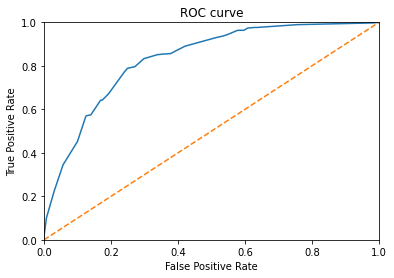


Threshold = 0.10 | accuracy = 0.590 | roc_auc = 0.701 | F1 = 0.557
Threshold = 0.12 | accuracy = 0.660 | roc_auc = 0.735 | F1 = 0.590
Threshold = 0.14 | accuracy = 0.680 | roc_auc = 0.737 | F1 = 0.594
Threshold = 0.16 | accuracy = 0.690 | roc_auc = 0.739 | F1 = 0.597
Threshold = 0.18 | accuracy = 0.690 | roc_auc = 0.739 | F1 = 0.597
Threshold = 0.20 | accuracy = 0.700 | roc_auc = 0.751 | F1 = 0.611
Threshold = 0.22 | accuracy = 0.700 | roc_auc = 0.751 | F1 = 0.611
Threshold = 0.24 | accuracy = 0.740 | roc_auc = 0.768 | F1 = 0.634
Threshold = 0.26 | accuracy = 0.750 | roc_auc = 0.762 | F1 = 0.631
Threshold = 0.28 | accuracy = 0.750 | roc_auc = 0.762 | F1 = 0.631
Threshold = 0.30 | accuracy = 0.760 | roc_auc = 0.766 | F1 = 0.640
Threshold = 0.32 | accuracy = 0.760 | roc_auc = 0.766 | F1 = 0.640
Threshold = 0.34 | accuracy = 0.760 | roc_auc = 0.766 | F1 = 0.640
Threshold = 0.36 | accuracy = 0.780 | roc_auc = 0.734 | F1 = 0.610
Threshold = 0.38 | accuracy = 0.780 | roc_auc = 0.737 | F1 = 

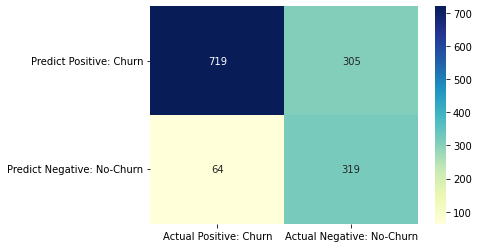


Top 10 important features


,features,importance
16,contract_type,0.504989
4,tenure,0.172843
21,internetservice_Fiber optic,0.141587
14,monthlycharges,0.078037
15,totalcharges,0.056168
19,paymentmethod_Electronic check,0.023395
5,phoneservice,0.009389
1,seniorcitizen,0.004827
12,streamingmovies,0.004277
9,deviceprotection,0.002131


Least 10 important features


,features,importance
22,internetservice_No,0.0
20,paymentmethod_Mailed check,0.0
2,partner,0.0
3,dependents,0.0
18,paymentmethod_Credit card (automatic),0.0
17,autopay,0.0
6,multiplelines,0.0
7,onlinesecurity,0.0
8,onlinebackup,0.0
13,paperlessbilling,0.0


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"


CPU times: user 21.9 s, sys: 11.6 s, total: 33.4 s
Wall time: 15.2 s


In [40]:
%%time

params  = {'model__min_samples_leaf':[3, 5, 10, 20], 
           'model__min_samples_split':[60, 90, 120], 
           'model__max_depth': [3, 5, 10]}
model   = DecisionTreeClassifier(random_state=12345)
name    ='Decision Tree with scaling'
results = train_predict(features_train, target_train, 
                        features_test, target_test, 
                        params, name, model)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

* DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120, random_state=12345)
* with score on the fit set: 0.84
* ROC AUC score on the prediction set: 0.83 accuracy: 0.74 for threshold: 0.24
* False Negatives(FN) =  64
* Top important features as we saw as well by the correlation are contract_type and tenure.
* Less important features are internetservice_No, paymentmethod_Mailed check.

##### Random Forest Model

Investigate the quality of the Random Forest, we will try adjusting the following set of hyperparameters:

— **n_estimators**: number of trees in the foreset

— **max_features**: max number of features considered for splitting a node

— **max_depth**: max number of levels in each decision tree

— **min_samples_leaf**: min number of data points allowed in a leaf node

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_features=4, min_samples_leaf=10,
                                        n_estimators=500,
                                        random_state=12345))])
ROC AUC score on the fit set: 0.85
ROC AUC score on the prediction set: 0.85


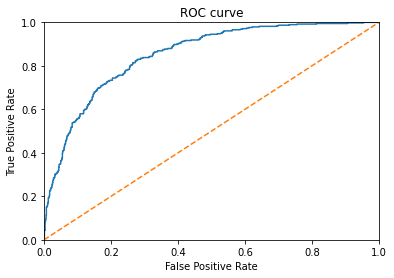


Threshold = 0.10 | accuracy = 0.600 | roc_auc = 0.712 | F1 = 0.566
Threshold = 0.12 | accuracy = 0.630 | roc_auc = 0.726 | F1 = 0.579
Threshold = 0.14 | accuracy = 0.650 | roc_auc = 0.732 | F1 = 0.586
Threshold = 0.16 | accuracy = 0.670 | roc_auc = 0.747 | F1 = 0.602
Threshold = 0.18 | accuracy = 0.690 | roc_auc = 0.754 | F1 = 0.611
Threshold = 0.20 | accuracy = 0.700 | roc_auc = 0.758 | F1 = 0.617
Threshold = 0.22 | accuracy = 0.720 | roc_auc = 0.764 | F1 = 0.627
Threshold = 0.24 | accuracy = 0.730 | roc_auc = 0.767 | F1 = 0.632
Threshold = 0.26 | accuracy = 0.750 | roc_auc = 0.774 | F1 = 0.644
Threshold = 0.28 | accuracy = 0.760 | roc_auc = 0.769 | F1 = 0.641
Threshold = 0.30 | accuracy = 0.760 | roc_auc = 0.761 | F1 = 0.635
Threshold = 0.32 | accuracy = 0.770 | roc_auc = 0.766 | F1 = 0.643
Threshold = 0.34 | accuracy = 0.790 | roc_auc = 0.768 | F1 = 0.651
Threshold = 0.36 | accuracy = 0.800 | roc_auc = 0.767 | F1 = 0.653
Threshold = 0.38 | accuracy = 0.800 | roc_auc = 0.760 | F1 = 

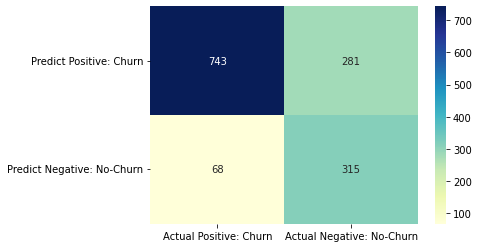


Top 10 important features


,features,importance
4,tenure,0.180460
16,contract_type,0.179928
15,totalcharges,0.128067
14,monthlycharges,0.114720
21,internetservice_Fiber optic,0.080180
19,paymentmethod_Electronic check,0.055406
22,internetservice_No,0.045292
7,onlinesecurity,0.025281
13,paperlessbilling,0.023377
10,techsupport,0.021901


Least 10 important features


,features,importance
5,phoneservice,0.006201
18,paymentmethod_Credit card (automatic),0.007734
20,paymentmethod_Mailed check,0.008237
9,deviceprotection,0.008377
3,dependents,0.010474
11,streamingtv,0.010642
0,gender,0.011323
1,seniorcitizen,0.011338
8,onlinebackup,0.011615
6,multiplelines,0.011716


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."


CPU times: user 5min 47s, sys: 13.3 s, total: 6min 1s
Wall time: 5min 42s


In [41]:
%%time

params= {'model__max_features':[2, 4, 6], 
         'model__min_samples_leaf':[5, 10, 20], 
         'model__n_estimators':[250, 500, 700], 
         'model__max_depth': [5, 10, 20, 30],
         'model__criterion':['gini', 'entropy']}

model = RandomForestClassifier(random_state=12345)
name  ='Random Forest with scaling'
rf = train_predict(features_train, target_train, 
                   features_test, target_test, params, name, model)
#append the new results 
results = results.append(rf)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

* RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_features=4, min_samples_leaf=10,
                                        n_estimators=500,
                                        random_state=12345)
* ROC AUC with score on the fit set: 0.85 
* ROC AUC score on the prediction set: 0.85
* Accuracy: 0.75 for threshold: 0.26
* False Negatives(FN) =  68
* Top important features as we saw as well by the correlation are contract_type and tenure.
* Less important features are phoneservice, paymentmethod_Credit card (automatic).
* The results are better than the DT.
* The results are the best but the time for the model training is much longer: 6 minutes.

##### Logistic Regression Model

In order to investigate the quality of the logistic regression, we will try adjusting the following set of hyperparameters:

— **solver** in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
Regularization (penalty) can sometimes be helpful. I took out ‘lbfgs’, ‘liblinear’ which made compatible issue with the penalty argument.

— **penalty** in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’] Used to specify the norm used in the penalization.
Note: not all solvers support all regularization terms.
The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. 
‘elasticnet’ is only supported by the ‘saga’ solver. 
If ‘none’ (not supported by the liblinear solver), no regularization is applied.
I took out the 'elasticnet','l1' which made compatible issue with the solver.

— The **C** parameter controls the penality strength, which can also be effective.
C in [100, 10, 1.0, 0.1, 0.01]

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=0.01, penalty='none', random_state=12345,
                                    solver='saga'))])
ROC AUC score on the fit set: 0.84
ROC AUC score on the prediction set: 0.85


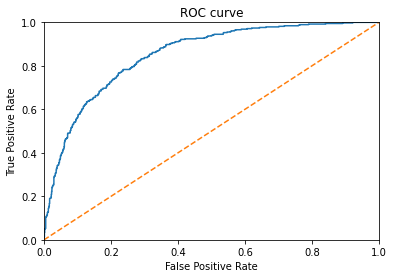


Threshold = 0.10 | accuracy = 0.630 | roc_auc = 0.724 | F1 = 0.578
Threshold = 0.12 | accuracy = 0.640 | roc_auc = 0.729 | F1 = 0.583
Threshold = 0.14 | accuracy = 0.670 | roc_auc = 0.747 | F1 = 0.601
Threshold = 0.16 | accuracy = 0.680 | roc_auc = 0.755 | F1 = 0.610
Threshold = 0.18 | accuracy = 0.700 | roc_auc = 0.762 | F1 = 0.620
Threshold = 0.20 | accuracy = 0.720 | roc_auc = 0.765 | F1 = 0.625
Threshold = 0.22 | accuracy = 0.730 | roc_auc = 0.769 | F1 = 0.632
Threshold = 0.24 | accuracy = 0.740 | roc_auc = 0.768 | F1 = 0.634
Threshold = 0.26 | accuracy = 0.750 | roc_auc = 0.767 | F1 = 0.636
Threshold = 0.28 | accuracy = 0.760 | roc_auc = 0.765 | F1 = 0.636
Threshold = 0.30 | accuracy = 0.770 | roc_auc = 0.771 | F1 = 0.646
Threshold = 0.32 | accuracy = 0.780 | roc_auc = 0.766 | F1 = 0.643
Threshold = 0.34 | accuracy = 0.780 | roc_auc = 0.761 | F1 = 0.640
Threshold = 0.36 | accuracy = 0.790 | roc_auc = 0.759 | F1 = 0.640
Threshold = 0.38 | accuracy = 0.790 | roc_auc = 0.758 | F1 = 

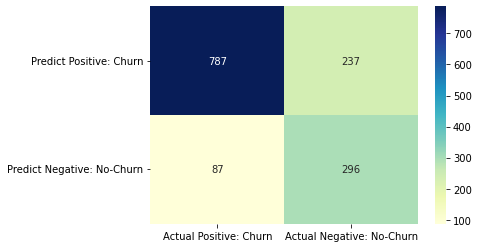

,feature,importance
4,tenure,4.346803
15,totalcharges,3.058767
16,contract_type,1.291807
14,monthlycharges,1.256975
22,internetservice_No,1.129829
21,internetservice_Fiber optic,1.023854
5,phoneservice,0.437956
12,streamingmovies,0.363218
7,onlinesecurity,0.352457
13,paperlessbilling,0.351488


Less 10 important features


,feature,importance
17,autopay,0.004558
9,deviceprotection,0.023668
20,paymentmethod_Mailed check,0.038824
0,gender,0.042909
2,partner,0.061738
3,dependents,0.104230
8,onlinebackup,0.132666
18,paymentmethod_Credit card (automatic),0.208509
1,seniorcitizen,0.230049
11,streamingtv,0.264808


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"


CPU times: user 54.8 s, sys: 37.2 s, total: 1min 31s
Wall time: 31.7 s


In [42]:
%%time
params = {'model__solver':['sag','saga','newton-cg'],#'lbfgs', 'liblinear',
              'model__penalty': ['l2','none'],# 'elasticnet','l1',
              'model__C':[100, 10, 1.0, 0.1, 0.01]}
model = LogisticRegression(random_state=12345)
name  ='Logistic Regression with scaling with all features'
lr = train_predict(features_train, target_train, 
                   features_test, target_test, 
                   params, name, model)
#append the new results 
results = results.append(lr)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

* LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga')
* with ROC AUC score on the fit set: 0.84
* ROC AUC score on the prediction set: 0.85 
* Accuracy: 0.77 for threshold: 0.3
* False Negatives(FN) =  87
* Top important features as we saw as well by the correlation are tenure and totalcharges.
* Less important features are autopay and deviceprotection. 
* The results are better than the DT and RF on the accuracy but not on the FNR.

#### Boosting Models - check which will be better LightGBM or XGBoost

##### LightGBM Model

**Tune Parameters for the Leaf-wise (Best-first) Tree**
LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.

To get good results using a leaf-wise tree, these are some important parameters:

— **num_leaves** This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

— **max_depth** You also can use max_depth to limit the tree depth explicitly.

— **n_estimators** An important hyperparameter for the LightGBM ensemble algorithm is the number of decision trees used in the ensemble. Recall that decision trees are added to the model sequentially in an effort to correct and improve upon the predictions made by prior trees. As such, more trees are often better.
The number of trees can be set via the “n_estimators” argument and defaults to 100.

— **learning_rate** last but not least the learning rate is totally impact on the score and should be tuned as well.

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3,
                                random_state=12345))])
ROC AUC score on the fit set: 0.84
ROC AUC score on the prediction set: 0.85


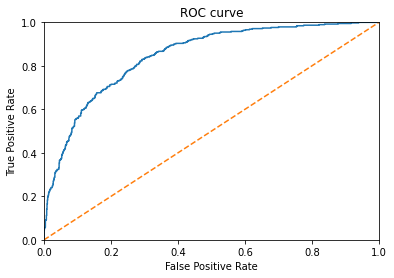


Threshold = 0.10 | accuracy = 0.640 | roc_auc = 0.728 | F1 = 0.581
Threshold = 0.12 | accuracy = 0.660 | roc_auc = 0.740 | F1 = 0.595
Threshold = 0.14 | accuracy = 0.680 | roc_auc = 0.749 | F1 = 0.605
Threshold = 0.16 | accuracy = 0.700 | roc_auc = 0.758 | F1 = 0.616
Threshold = 0.18 | accuracy = 0.710 | roc_auc = 0.756 | F1 = 0.616
Threshold = 0.20 | accuracy = 0.720 | roc_auc = 0.763 | F1 = 0.625
Threshold = 0.22 | accuracy = 0.730 | roc_auc = 0.763 | F1 = 0.627
Threshold = 0.24 | accuracy = 0.740 | roc_auc = 0.769 | F1 = 0.635
Threshold = 0.26 | accuracy = 0.740 | roc_auc = 0.764 | F1 = 0.632
Threshold = 0.28 | accuracy = 0.750 | roc_auc = 0.763 | F1 = 0.634
Threshold = 0.30 | accuracy = 0.760 | roc_auc = 0.760 | F1 = 0.633
Threshold = 0.32 | accuracy = 0.770 | roc_auc = 0.755 | F1 = 0.631
Threshold = 0.34 | accuracy = 0.780 | roc_auc = 0.756 | F1 = 0.635
Threshold = 0.36 | accuracy = 0.790 | roc_auc = 0.757 | F1 = 0.639
Threshold = 0.38 | accuracy = 0.800 | roc_auc = 0.757 | F1 = 

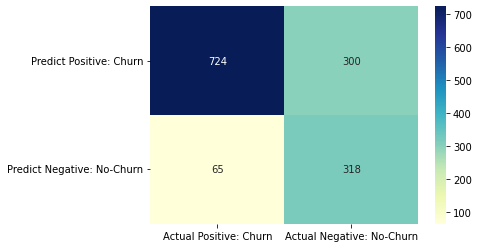


Top 10 important features


,features,importance
14,monthlycharges,485
15,totalcharges,465
4,tenure,197
16,contract_type,72
0,gender,34
6,multiplelines,34
20,paymentmethod_Mailed check,28
18,paymentmethod_Credit card (automatic),28
1,seniorcitizen,28
13,paperlessbilling,25


Least 10 important features


,features,importance
2,partner,1
9,deviceprotection,6
19,paymentmethod_Electronic check,11
22,internetservice_No,13
21,internetservice_Fiber optic,13
3,dependents,15
11,streamingtv,18
8,onlinebackup,19
12,streamingmovies,19
17,autopay,21


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"


CPU times: user 3min 39s, sys: 16.5 s, total: 3min 55s
Wall time: 1min 6s


In [43]:
%%time
model = LGBMClassifier(random_state=12345)

params = {    
    "model__max_depth" : [2, 5, 10],
    "model__num_leaves" : [3, 5, 15, 30, 90],
    "model__n_estimators" : [600, 800, 1000],
    "model__learning_rate" : [0.1, 0.3, 0.5, 0.7]
    }

# # the rest of the hyper parameters in order we would like to add more later:
# #     "model__subsample_freq": [5],
# #     "model__subsample" : [0.3],
# #     "model__colsample_bytree" : [0.05],
# #     "model__min_child_samples": [100],
# #     "model__min_child_weight": [10],
# #     "model__reg_alpha" : [0.12],
# #     "model__reg_lambda" : [15.5],    "model__min_data_in_leaf" : [10,100,500,1000]


name  ='Light GBM with scaling'
lgb = train_predict(features_train, target_train, 
                    features_test, target_test, params, name, model)
#append the new results 
results = results.append(lgb)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

* LGBMClassifier(boosting_type='gbdt', class_weight=None,
    colsample_bytree=1.0, importance_type='split',
    learning_rate=0.3, max_depth=2,
    min_child_samples=20, min_child_weight=0.001,
    min_split_gain=0.0, n_estimators=800, n_jobs=-1,
    num_leaves=5, objective=None,
    random_state=12345, reg_alpha=0.0,
    reg_lambda=0.0, silent=True, subsample=1.0,
    subsample_for_bin=200000, subsample_freq=0)
* with ROC AUC score on the fit set: 0.83
* ROC AUC score on the prediction set: 0.84 accuracy: 0.73 for threshold: 0.22
* False Negatives(FN) =  69 
* Top important features as we saw as well by the correlation are monthlycharges and totalcharges.
* Less important features are internetservice_No and internetservice_Fiber optic. 
* looking into the thresholds check, we can see that the best F1 is not the same for the roc auc but more similar to the accuracy:
  * For best roc_auc: Threshold = 0.22 | accuracy = 0.730 | roc_auc = 0.756 | F1 = 0.621
  * For best Accuracy: 0.88 from 0.44
  * For best F1: Threshold = 0.30 | accuracy = 0.760 | roc_auc = 0.753 | F1 = 0.627
* The roc auc for the threshold is lower than the total because its calculated by the values and not by the propabilities on the specific threshold.


##### XGBoost Model

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='auc', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=12345, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               

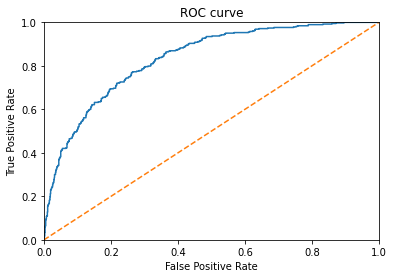


Threshold = 0.10 | accuracy = 0.650 | roc_auc = 0.732 | F1 = 0.587
Threshold = 0.12 | accuracy = 0.670 | roc_auc = 0.733 | F1 = 0.589
Threshold = 0.14 | accuracy = 0.690 | roc_auc = 0.745 | F1 = 0.603
Threshold = 0.16 | accuracy = 0.700 | roc_auc = 0.744 | F1 = 0.604
Threshold = 0.18 | accuracy = 0.710 | roc_auc = 0.748 | F1 = 0.610
Threshold = 0.20 | accuracy = 0.710 | roc_auc = 0.744 | F1 = 0.606
Threshold = 0.22 | accuracy = 0.730 | roc_auc = 0.747 | F1 = 0.612
Threshold = 0.24 | accuracy = 0.740 | roc_auc = 0.754 | F1 = 0.623
Threshold = 0.26 | accuracy = 0.750 | roc_auc = 0.747 | F1 = 0.617
Threshold = 0.28 | accuracy = 0.750 | roc_auc = 0.745 | F1 = 0.616
Threshold = 0.30 | accuracy = 0.760 | roc_auc = 0.743 | F1 = 0.616
Threshold = 0.32 | accuracy = 0.770 | roc_auc = 0.746 | F1 = 0.622
Threshold = 0.34 | accuracy = 0.780 | roc_auc = 0.739 | F1 = 0.616
Threshold = 0.36 | accuracy = 0.780 | roc_auc = 0.733 | F1 = 0.608
Threshold = 0.38 | accuracy = 0.790 | roc_auc = 0.736 | F1 = 

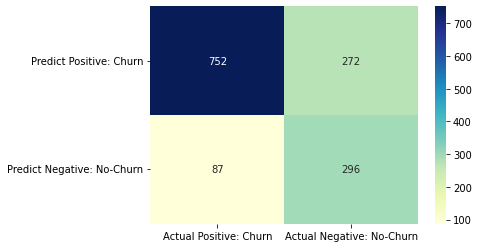


Top 10 important features


,features,importance
21,internetservice_Fiber optic,0.314785
16,contract_type,0.234552
22,internetservice_No,0.123750
19,paymentmethod_Electronic check,0.042242
12,streamingmovies,0.036794
4,tenure,0.025830
7,onlinesecurity,0.023870
10,techsupport,0.022017
5,phoneservice,0.020008
11,streamingtv,0.019046


Least 10 important features


,features,importance
14,monthlycharges,0.008793
3,dependents,0.008808
20,paymentmethod_Mailed check,0.009102
18,paymentmethod_Credit card (automatic),0.009132
0,gender,0.009138
17,autopay,0.009382
15,totalcharges,0.009956
2,partner,0.009995
8,onlinebackup,0.011162
9,deviceprotection,0.011511


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"


CPU times: user 1h 7min 56s, sys: 21.6 s, total: 1h 8min 18s
Wall time: 17min 49s


In [44]:
%%time
# this step takes about 20 mins
model = XGBClassifier(objective='binary:logistic', random_state=12345)
params = {    
    "model__max_depth" : [3, 5, 10],
    "model__n_estimators" : [1000,1200,1350],
    "model__learning_rate" : [0.1,0.3,0.5,0.7],
    'model__eval_metric': ['auc','aucpr']
#    'model__min_child_weight': [1, 5, 10]
#    'model__gamma': [0.01]
#     'model__subsample': [0.6, 0.8, 1.0],
#     'model__colsample_bytree': [0.6, 0.8, 1.0]
    }

name  ='XGBoost with scaling'
xgbt = train_predict(features_train, target_train, 
                     features_test, target_test, 
                     params, name, model)

#append the new results 
results = results.append(xgbt)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

* XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='auc', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=12345, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None)
* with ROC AUC score on the fit set: 0.82
* ROC AUC score on the prediction set: 0.83 
* accuracy: 0.74 for threshold: 0.24
* False Negatives(FN) =  87
* Top important features as we saw as well by the correlation are internetservice_Fiber optic and contract_type the less important feature for LGBM is here the most important.
* Less important features are monthlycharges and dependents. which is really weird because monthlycharges was in the top for the target correlation, but still we got the best scores.
* The results are similar to the LGBM results and the time for the model training is very long: 20 minutes.

##### Knn Model

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model', KNeighborsClassifier(n_neighbors=50))])
ROC AUC score on the fit set: 0.83
ROC AUC score on the prediction set: 0.82


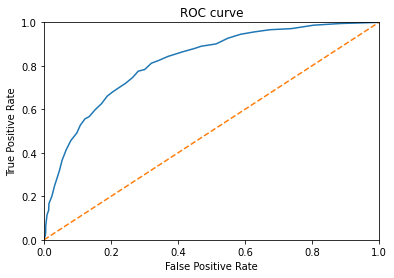


Threshold = 0.10 | accuracy = 0.560 | roc_auc = 0.679 | F1 = 0.538
Threshold = 0.12 | accuracy = 0.580 | roc_auc = 0.689 | F1 = 0.546
Threshold = 0.14 | accuracy = 0.600 | roc_auc = 0.694 | F1 = 0.550
Threshold = 0.16 | accuracy = 0.630 | roc_auc = 0.710 | F1 = 0.566
Threshold = 0.18 | accuracy = 0.640 | roc_auc = 0.715 | F1 = 0.571
Threshold = 0.20 | accuracy = 0.660 | roc_auc = 0.726 | F1 = 0.582
Threshold = 0.22 | accuracy = 0.690 | roc_auc = 0.737 | F1 = 0.595
Threshold = 0.24 | accuracy = 0.700 | roc_auc = 0.741 | F1 = 0.602
Threshold = 0.26 | accuracy = 0.720 | roc_auc = 0.746 | F1 = 0.609
Threshold = 0.28 | accuracy = 0.720 | roc_auc = 0.741 | F1 = 0.605
Threshold = 0.30 | accuracy = 0.730 | roc_auc = 0.747 | F1 = 0.614
Threshold = 0.32 | accuracy = 0.740 | roc_auc = 0.741 | F1 = 0.609
Threshold = 0.34 | accuracy = 0.750 | roc_auc = 0.738 | F1 = 0.607
Threshold = 0.36 | accuracy = 0.760 | roc_auc = 0.738 | F1 = 0.609
Threshold = 0.38 | accuracy = 0.760 | roc_auc = 0.738 | F1 = 

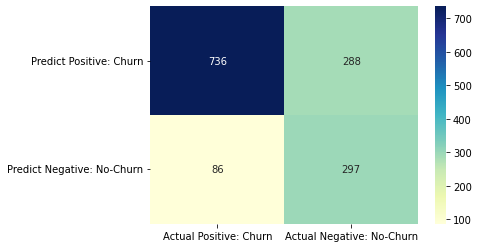


there is no feature_importances_ attribute on this model


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"


CPU times: user 41 s, sys: 10.7 s, total: 51.7 s
Wall time: 34.9 s


In [45]:
%%time
# this step takes about 20 mins
model = KNeighborsClassifier()
params = { "model__n_neighbors" : [20, 50, 150, 250] }

name  ='Knn with scaling'
xgbt = train_predict(features_train, target_train, 
                     features_test, target_test, 
                     params, name, model)

#append the new results 
results = results.append(xgbt)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

* KNeighborsClassifier(n_neighbors=50)
* with ROC AUC score on the fit set: 0.83
* ROC AUC score on the prediction set: 0.82 
* accuracy: 0.73 for threshold: 0.3
* False Negatives(FN) =  86
* This is the worst model from all, maybe I could tune it more, but the simple models are the winners so I will leave it. still the Knn is very fast trainer. 

### Conclusions:
* The tuning of the hyper parameter first started on the simple models of trees and logistic regression which got nice scores, still I moved on to the boosting models which got worse scores than RF and LR.
* The best models on the imbalanced classes are Random Forest and Logistic Regression with Roc auc score higher than 0.85 on the test and accuracy 0.75/7

<a id='section3'></a>
## Taking into account the imbalance of classes using Class weight adjustment
Train the best models that we had on the imbalace of classes and check their score with balance of classes.

*Class weight adjustment*
Some models have *class_weight* argument. By default, it is `None` — i.e., classes are equivalent:
`class "0" weight = 1.0`
`class "1" weight = 1.0`

If we specify `class_weight='balanced'`, the algorithm will calculate how many times class "0" occurs more often than class "1". We’ll denote this number as N (an unknown number of times). The new class weights look like this:
`class "0" weight = 1.0`
`class "1" weight = N`
The rare class will have a higher weight.

Similar adjustment can be done by the parameter `scale_pos_weight` by default=1
Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances) -> In our case this is 2.76 calculated by the target distributed section details we had on 1.5.

Lets try it on our models using Class weight adjustment:

### Decision Tree

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=20,
                                        min_samples_split=120,
                                        random_state=12345))])
ROC AUC score on the fit set: 0.83
ROC AUC score on the prediction set: 0.84


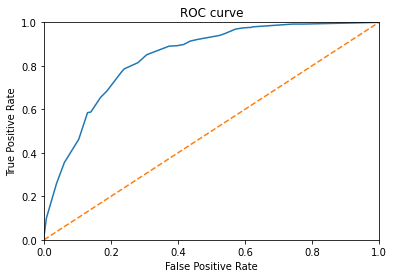


Threshold = 0.10 | accuracy = 0.540 | roc_auc = 0.679 | F1 = 0.538
Threshold = 0.12 | accuracy = 0.540 | roc_auc = 0.679 | F1 = 0.538
Threshold = 0.14 | accuracy = 0.550 | roc_auc = 0.683 | F1 = 0.541
Threshold = 0.16 | accuracy = 0.550 | roc_auc = 0.683 | F1 = 0.541
Threshold = 0.18 | accuracy = 0.560 | roc_auc = 0.692 | F1 = 0.548
Threshold = 0.20 | accuracy = 0.590 | roc_auc = 0.704 | F1 = 0.559
Threshold = 0.22 | accuracy = 0.590 | roc_auc = 0.704 | F1 = 0.559
Threshold = 0.24 | accuracy = 0.640 | roc_auc = 0.731 | F1 = 0.585
Threshold = 0.26 | accuracy = 0.640 | roc_auc = 0.731 | F1 = 0.585
Threshold = 0.28 | accuracy = 0.660 | roc_auc = 0.739 | F1 = 0.593
Threshold = 0.30 | accuracy = 0.660 | roc_auc = 0.739 | F1 = 0.593
Threshold = 0.32 | accuracy = 0.660 | roc_auc = 0.739 | F1 = 0.593
Threshold = 0.34 | accuracy = 0.670 | roc_auc = 0.741 | F1 = 0.596
Threshold = 0.36 | accuracy = 0.670 | roc_auc = 0.741 | F1 = 0.596
Threshold = 0.38 | accuracy = 0.680 | roc_auc = 0.747 | F1 = 

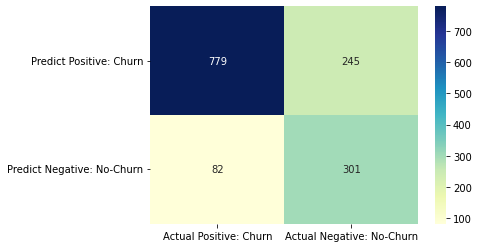


Top 10 important features


,features,importance
16,contract_type,0.616220
4,tenure,0.134112
21,internetservice_Fiber optic,0.094579
14,monthlycharges,0.074640
15,totalcharges,0.024382
19,paymentmethod_Electronic check,0.017583
12,streamingmovies,0.016120
5,phoneservice,0.012646
1,seniorcitizen,0.005102
11,streamingtv,0.003124


Least 10 important features


,features,importance
0,gender,0.0
20,paymentmethod_Mailed check,0.0
18,paymentmethod_Credit card (automatic),0.0
17,autopay,0.0
13,paperlessbilling,0.0
10,techsupport,0.0
9,deviceprotection,0.0
8,onlinebackup,0.0
22,internetservice_No,0.0
6,multiplelines,0.0


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"


CPU times: user 21.7 s, sys: 11.6 s, total: 33.3 s
Wall time: 15.1 s


In [46]:
%%time

params  = {'model__min_samples_leaf':[3, 5, 10, 20], 
           'model__min_samples_split':[60, 90, 120], 
           'model__max_depth': [3, 5, 10]}
model   = DecisionTreeClassifier(class_weight='balanced', random_state=12345)
name    ='Decision Tree with scaling and class_weight balanced on all features'
dt = train_predict(features_train, target_train, 
                        features_test, target_test, 
                        params, name, model)
#append the new results 
results = results.append(dt)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

### Random Forest Model

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=10,
                                        max_features=4, min_samples_leaf=10,
                                        n_estimators=250,
                                        random_state=12345))])
ROC AUC score on the fit set: 0.85
ROC AUC score on the prediction set: 0.85


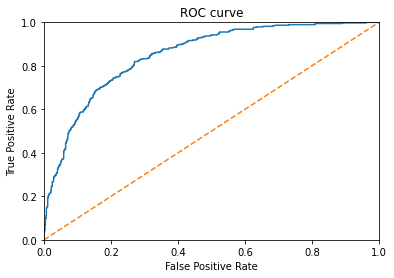


Threshold = 0.10 | accuracy = 0.500 | roc_auc = 0.649 | F1 = 0.515
Threshold = 0.12 | accuracy = 0.520 | roc_auc = 0.664 | F1 = 0.527
Threshold = 0.14 | accuracy = 0.540 | roc_auc = 0.675 | F1 = 0.535
Threshold = 0.16 | accuracy = 0.560 | roc_auc = 0.686 | F1 = 0.543
Threshold = 0.18 | accuracy = 0.570 | roc_auc = 0.698 | F1 = 0.553
Threshold = 0.20 | accuracy = 0.590 | roc_auc = 0.707 | F1 = 0.562
Threshold = 0.22 | accuracy = 0.610 | roc_auc = 0.715 | F1 = 0.569
Threshold = 0.24 | accuracy = 0.630 | roc_auc = 0.727 | F1 = 0.580
Threshold = 0.26 | accuracy = 0.640 | roc_auc = 0.733 | F1 = 0.587
Threshold = 0.28 | accuracy = 0.660 | roc_auc = 0.737 | F1 = 0.591
Threshold = 0.30 | accuracy = 0.670 | roc_auc = 0.742 | F1 = 0.597
Threshold = 0.32 | accuracy = 0.680 | roc_auc = 0.747 | F1 = 0.603
Threshold = 0.34 | accuracy = 0.690 | roc_auc = 0.750 | F1 = 0.608
Threshold = 0.36 | accuracy = 0.700 | roc_auc = 0.757 | F1 = 0.617
Threshold = 0.38 | accuracy = 0.710 | roc_auc = 0.760 | F1 = 

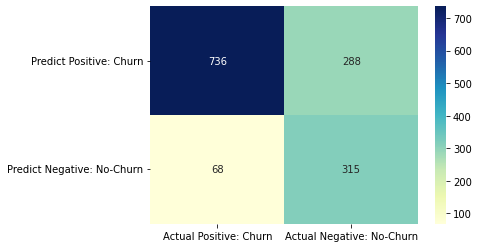


Top 10 important features


,features,importance
16,contract_type,0.196559
4,tenure,0.172732
15,totalcharges,0.124351
14,monthlycharges,0.116369
21,internetservice_Fiber optic,0.076674
19,paymentmethod_Electronic check,0.054387
22,internetservice_No,0.046366
13,paperlessbilling,0.025719
7,onlinesecurity,0.023314
17,autopay,0.021352


Least 10 important features


,features,importance
5,phoneservice,0.005823
20,paymentmethod_Mailed check,0.007936
9,deviceprotection,0.008418
18,paymentmethod_Credit card (automatic),0.008823
1,seniorcitizen,0.009518
6,multiplelines,0.010392
8,onlinebackup,0.010614
3,dependents,0.010819
11,streamingtv,0.010924
0,gender,0.011780


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."


CPU times: user 5min 21s, sys: 13.2 s, total: 5min 34s
Wall time: 5min 15s


In [47]:
%%time

params= {'model__max_features':[2, 4, 6], 
         'model__min_samples_leaf':[5, 10, 20], 
         'model__n_estimators':[250, 500, 700], 
         'model__max_depth': [5, 10, 20, 30],
         'model__criterion':['gini', 'entropy']}

model = RandomForestClassifier(class_weight='balanced',random_state=12345)
name  ='Random Forest with scaling and class_weight balanced on all features'
rf = train_predict(features_train, target_train, 
                   features_test, target_test, params, name, model)
#append the new results 
results = results.append(rf)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

<a id='winner'></a>
* Training the model again with its top important features only:

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=20,
                                        max_features=2, min_samples_leaf=20,
                                        n_estimators=500,
                                        random_state=12345))])
ROC AUC score on the fit set: 0.85
ROC AUC score on the prediction set: 0.85


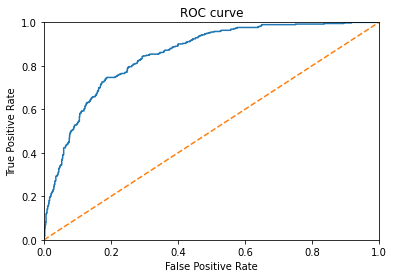


Threshold = 0.10 | accuracy = 0.490 | roc_auc = 0.647 | F1 = 0.514
Threshold = 0.12 | accuracy = 0.510 | roc_auc = 0.663 | F1 = 0.526
Threshold = 0.14 | accuracy = 0.530 | roc_auc = 0.672 | F1 = 0.532
Threshold = 0.16 | accuracy = 0.550 | roc_auc = 0.685 | F1 = 0.543
Threshold = 0.18 | accuracy = 0.560 | roc_auc = 0.693 | F1 = 0.550
Threshold = 0.20 | accuracy = 0.580 | roc_auc = 0.702 | F1 = 0.557
Threshold = 0.22 | accuracy = 0.600 | roc_auc = 0.712 | F1 = 0.566
Threshold = 0.24 | accuracy = 0.620 | roc_auc = 0.723 | F1 = 0.576
Threshold = 0.26 | accuracy = 0.630 | roc_auc = 0.731 | F1 = 0.584
Threshold = 0.28 | accuracy = 0.650 | roc_auc = 0.735 | F1 = 0.588
Threshold = 0.30 | accuracy = 0.660 | roc_auc = 0.738 | F1 = 0.593
Threshold = 0.32 | accuracy = 0.670 | roc_auc = 0.745 | F1 = 0.601
Threshold = 0.34 | accuracy = 0.690 | roc_auc = 0.749 | F1 = 0.606
Threshold = 0.36 | accuracy = 0.690 | roc_auc = 0.750 | F1 = 0.608
Threshold = 0.38 | accuracy = 0.710 | roc_auc = 0.755 | F1 = 

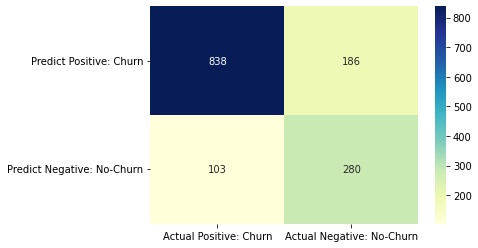


Top 10 important features


,features,importance
3,contract_type,0.219762
2,tenure,0.204733
1,totalcharges,0.146602
0,monthlycharges,0.130516
4,internetservice_Fiber optic,0.102342
5,paymentmethod_Electronic check,0.068227
6,internetservice_No,0.049341
7,onlinesecurity,0.028271
8,autopay,0.026451
9,paperlessbilling,0.023756


Least 10 important features


,features,importance
9,paperlessbilling,0.023756
8,autopay,0.026451
7,onlinesecurity,0.028271
6,internetservice_No,0.049341
5,paymentmethod_Electronic check,0.068227
4,internetservice_Fiber optic,0.102342
0,monthlycharges,0.130516
1,totalcharges,0.146602
2,tenure,0.204733
3,contract_type,0.219762


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Random Forest with scaling and class_weight balanced on 10 top important features only,0.85,391.806129,0.85,0.79,0.109,0.261996,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,

CPU times: user 6min 38s, sys: 13.1 s, total: 6min 51s
Wall time: 6min 32s


In [48]:
%%time

params= {'model__max_features':[2, 4, 6], 
         'model__min_samples_leaf':[5, 10, 20], 
         'model__n_estimators':[250, 500, 700], 
         'model__max_depth': [5, 10, 20, 30],
         'model__criterion':['gini', 'entropy']}

columns=['monthlycharges','totalcharges','tenure','contract_type','internetservice_Fiber optic',
         'paymentmethod_Electronic check', 'internetservice_No', 'onlinesecurity', 'autopay',
         'paperlessbilling']
model = RandomForestClassifier(class_weight='balanced',random_state=12345)
name  ='Random Forest with scaling and class_weight balanced on 10 top important features only'
rf = train_predict(features_train[columns], target_train, features_test[columns], 
                   target_test, params, name, model)
                    
#append the new results 
results = results.append(rf)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

### Logistic Regression Model

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    penalty='none', random_state=12345,
                                    solver='saga'))])
ROC AUC score on the fit set: 0.84
ROC AUC score on the prediction set: 0.85


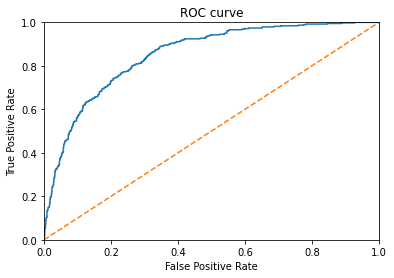


Threshold = 0.10 | accuracy = 0.500 | roc_auc = 0.648 | F1 = 0.514
Threshold = 0.12 | accuracy = 0.520 | roc_auc = 0.663 | F1 = 0.525
Threshold = 0.14 | accuracy = 0.550 | roc_auc = 0.680 | F1 = 0.539
Threshold = 0.16 | accuracy = 0.560 | roc_auc = 0.690 | F1 = 0.547
Threshold = 0.18 | accuracy = 0.590 | roc_auc = 0.706 | F1 = 0.560
Threshold = 0.20 | accuracy = 0.590 | roc_auc = 0.704 | F1 = 0.559
Threshold = 0.22 | accuracy = 0.610 | roc_auc = 0.713 | F1 = 0.567
Threshold = 0.24 | accuracy = 0.620 | roc_auc = 0.723 | F1 = 0.576
Threshold = 0.26 | accuracy = 0.630 | roc_auc = 0.723 | F1 = 0.577
Threshold = 0.28 | accuracy = 0.640 | roc_auc = 0.730 | F1 = 0.584
Threshold = 0.30 | accuracy = 0.650 | roc_auc = 0.739 | F1 = 0.593
Threshold = 0.32 | accuracy = 0.670 | roc_auc = 0.747 | F1 = 0.601
Threshold = 0.34 | accuracy = 0.670 | roc_auc = 0.751 | F1 = 0.605
Threshold = 0.36 | accuracy = 0.690 | roc_auc = 0.758 | F1 = 0.614
Threshold = 0.38 | accuracy = 0.700 | roc_auc = 0.763 | F1 = 

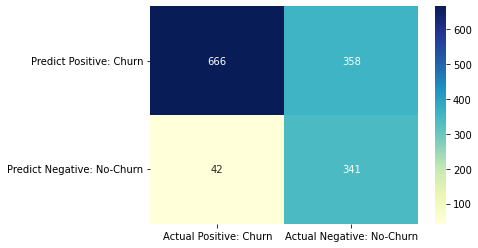

,feature,importance
4,tenure,4.007947
15,totalcharges,2.838160
14,monthlycharges,1.720938
16,contract_type,1.373550
22,internetservice_No,1.257643
21,internetservice_Fiber optic,1.108604
19,paymentmethod_Electronic check,0.564135
12,streamingmovies,0.436759
11,streamingtv,0.334953
5,phoneservice,0.328095


Less 10 important features


,feature,importance
9,deviceprotection,0.037808
0,gender,0.042263
2,partner,0.069488
8,onlinebackup,0.092961
3,dependents,0.106349
20,paymentmethod_Mailed check,0.203892
18,paymentmethod_Credit card (automatic),0.209631
1,seniorcitizen,0.236631
17,autopay,0.260151
10,techsupport,0.289683


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Random Forest with scaling and class_weight balanced on 10 top important features only,0.85,391.806129,0.85,0.79,0.109,0.261996,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,

CPU times: user 54.6 s, sys: 37.1 s, total: 1min 31s
Wall time: 31.7 s


In [49]:
%%time
params = {'model__solver':['sag','saga','newton-cg'],#'lbfgs', 'liblinear',
              'model__penalty': ['l2','none'],# 'elasticnet','l1',
              'model__C':[100, 10, 1.0, 0.1, 0.01]}
model = LogisticRegression(class_weight='balanced', random_state=12345)
name  ='Logistic Regression with scaling and class_weight balanced on all features'
lr = train_predict(features_train, target_train, 
                   features_test, target_test, 
                   params, name, model)
#append the new results 
results = results.append(lr)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

* Training the model again with its top important features only:

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', penalty='none',
                                    random_state=12345, solver='sag'))])
ROC AUC score on the fit set: 0.84
ROC AUC score on the prediction set: 0.85


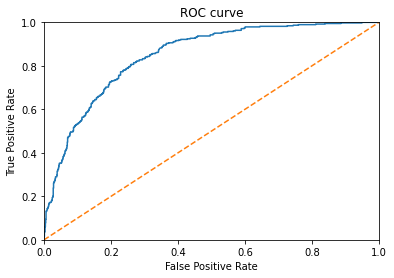


Threshold = 0.10 | accuracy = 0.480 | roc_auc = 0.639 | F1 = 0.508
Threshold = 0.12 | accuracy = 0.510 | roc_auc = 0.655 | F1 = 0.520
Threshold = 0.14 | accuracy = 0.530 | roc_auc = 0.670 | F1 = 0.531
Threshold = 0.16 | accuracy = 0.560 | roc_auc = 0.690 | F1 = 0.547
Threshold = 0.18 | accuracy = 0.580 | roc_auc = 0.696 | F1 = 0.552
Threshold = 0.20 | accuracy = 0.600 | roc_auc = 0.709 | F1 = 0.563
Threshold = 0.22 | accuracy = 0.610 | roc_auc = 0.715 | F1 = 0.569
Threshold = 0.24 | accuracy = 0.620 | roc_auc = 0.722 | F1 = 0.575
Threshold = 0.26 | accuracy = 0.630 | roc_auc = 0.725 | F1 = 0.578
Threshold = 0.28 | accuracy = 0.640 | roc_auc = 0.732 | F1 = 0.585
Threshold = 0.30 | accuracy = 0.650 | roc_auc = 0.738 | F1 = 0.592
Threshold = 0.32 | accuracy = 0.650 | roc_auc = 0.739 | F1 = 0.593
Threshold = 0.34 | accuracy = 0.660 | roc_auc = 0.746 | F1 = 0.600
Threshold = 0.36 | accuracy = 0.680 | roc_auc = 0.756 | F1 = 0.611
Threshold = 0.38 | accuracy = 0.690 | roc_auc = 0.761 | F1 = 

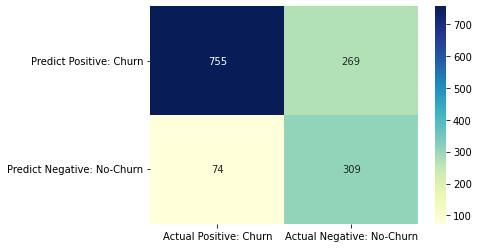

,feature,importance
2,tenure,3.935222
1,totalcharges,2.892671
0,monthlycharges,2.830009
6,internetservice_No,1.566464
4,internetservice_Fiber optic,1.561832
3,contract_type,1.548880
7,streamingmovies,0.600911
8,streamingtv,0.482528
5,paymentmethod_Electronic check,0.441914
9,techsupport,0.292075


Less 10 important features


,feature,importance
9,techsupport,0.292075
5,paymentmethod_Electronic check,0.441914
8,streamingtv,0.482528
7,streamingmovies,0.600911
3,contract_type,1.548880
4,internetservice_Fiber optic,1.561832
6,internetservice_No,1.566464
0,monthlycharges,2.830009
1,totalcharges,2.892671
2,tenure,3.935222


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Random Forest with scaling and class_weight balanced on 10 top important features only,0.85,391.806129,0.85,0.79,0.109,0.261996,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,

CPU times: user 29.6 s, sys: 17.5 s, total: 47.1 s
Wall time: 19.3 s


In [50]:
%%time
params = {'model__solver':['sag','saga','newton-cg'],#'lbfgs', 'liblinear',
              'model__penalty': ['l2','none'],# 'elasticnet','l1',
              'model__C':[100, 10, 1.0, 0.1, 0.01]}
model = LogisticRegression(class_weight='balanced', random_state=12345)
columns=['monthlycharges','totalcharges','tenure','contract_type','internetservice_Fiber optic',
         'paymentmethod_Electronic check', 'internetservice_No', 'streamingmovies', 'streamingtv',
         'techsupport']
name  ='Logistic Regression with scaling and class_weight balanced on 10 top important features only'
lr = train_predict(features_train[columns], target_train, features_test[columns], target_test, params, name, model)
      
#append the new results 
results = results.append(lr)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

### LightGBM Model

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.3,
                                max_depth=2, n_estimators=800, num_leaves=3,
                                random_state=12345))])
ROC AUC score on the fit set: 0.83
ROC AUC score on the prediction set: 0.84


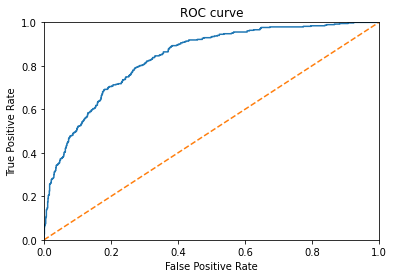


Threshold = 0.10 | accuracy = 0.560 | roc_auc = 0.681 | F1 = 0.539
Threshold = 0.12 | accuracy = 0.570 | roc_auc = 0.694 | F1 = 0.550
Threshold = 0.14 | accuracy = 0.590 | roc_auc = 0.702 | F1 = 0.557
Threshold = 0.16 | accuracy = 0.610 | roc_auc = 0.711 | F1 = 0.566
Threshold = 0.18 | accuracy = 0.620 | roc_auc = 0.717 | F1 = 0.571
Threshold = 0.20 | accuracy = 0.630 | roc_auc = 0.723 | F1 = 0.577
Threshold = 0.22 | accuracy = 0.640 | roc_auc = 0.726 | F1 = 0.581
Threshold = 0.24 | accuracy = 0.650 | roc_auc = 0.736 | F1 = 0.591
Threshold = 0.26 | accuracy = 0.660 | roc_auc = 0.743 | F1 = 0.597
Threshold = 0.28 | accuracy = 0.680 | roc_auc = 0.748 | F1 = 0.603
Threshold = 0.30 | accuracy = 0.680 | roc_auc = 0.750 | F1 = 0.606
Threshold = 0.32 | accuracy = 0.700 | roc_auc = 0.755 | F1 = 0.612
Threshold = 0.34 | accuracy = 0.700 | roc_auc = 0.749 | F1 = 0.608
Threshold = 0.36 | accuracy = 0.700 | roc_auc = 0.750 | F1 = 0.610
Threshold = 0.38 | accuracy = 0.710 | roc_auc = 0.753 | F1 = 

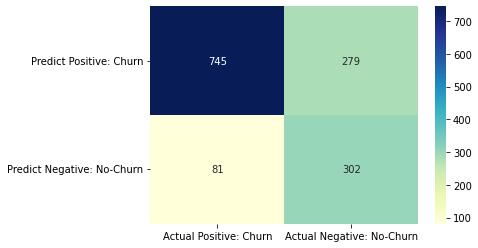


Top 10 important features


,features,importance
14,monthlycharges,554
15,totalcharges,471
4,tenure,239
16,contract_type,51
0,gender,35
17,autopay,24
13,paperlessbilling,23
10,techsupport,20
18,paymentmethod_Credit card (automatic),19
20,paymentmethod_Mailed check,18


Least 10 important features


,features,importance
22,internetservice_No,5
2,partner,7
21,internetservice_Fiber optic,7
12,streamingmovies,8
5,phoneservice,9
9,deviceprotection,10
19,paymentmethod_Electronic check,12
8,onlinebackup,13
11,streamingtv,13
6,multiplelines,14


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Random Forest with scaling and class_weight balanced on 10 top important features only,0.85,391.806129,0.85,0.79,0.109,0.261996,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,

CPU times: user 4min 33s, sys: 18.3 s, total: 4min 51s
Wall time: 1min 20s


In [51]:
%%time
model = LGBMClassifier(class_weight='balanced',random_state=12345)

params = {                 
            "model__max_depth" : [2, 5, 10],
            "model__num_leaves" : [3, 5, 15, 30, 90],
            "model__n_estimators" : [800, 1000, 1200],
            "model__learning_rate" : [0.3, 0.5, 0.7, 0.8]
         }

name  ='Light GBM with scaling and class_weight balanced on all features'
lgb = train_predict(features_train, target_train, features_test, target_test, params, name, model)
#append the new results 
results = results.append(lgb)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.3,
                                max_depth=2, n_estimators=800, num_leaves=3,
                                random_state=12345))])
ROC AUC score on the fit set: 0.82
ROC AUC score on the prediction set: 0.83


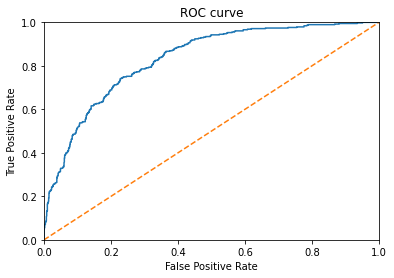


Threshold = 0.10 | accuracy = 0.560 | roc_auc = 0.684 | F1 = 0.542
Threshold = 0.12 | accuracy = 0.570 | roc_auc = 0.694 | F1 = 0.550
Threshold = 0.14 | accuracy = 0.590 | roc_auc = 0.702 | F1 = 0.557
Threshold = 0.16 | accuracy = 0.600 | roc_auc = 0.706 | F1 = 0.561
Threshold = 0.18 | accuracy = 0.610 | roc_auc = 0.713 | F1 = 0.568
Threshold = 0.20 | accuracy = 0.620 | roc_auc = 0.720 | F1 = 0.574
Threshold = 0.22 | accuracy = 0.640 | roc_auc = 0.730 | F1 = 0.584
Threshold = 0.24 | accuracy = 0.650 | roc_auc = 0.736 | F1 = 0.590
Threshold = 0.26 | accuracy = 0.660 | roc_auc = 0.739 | F1 = 0.593
Threshold = 0.28 | accuracy = 0.660 | roc_auc = 0.736 | F1 = 0.592
Threshold = 0.30 | accuracy = 0.670 | roc_auc = 0.739 | F1 = 0.595
Threshold = 0.32 | accuracy = 0.680 | roc_auc = 0.743 | F1 = 0.600
Threshold = 0.34 | accuracy = 0.690 | roc_auc = 0.745 | F1 = 0.603
Threshold = 0.36 | accuracy = 0.700 | roc_auc = 0.750 | F1 = 0.609
Threshold = 0.38 | accuracy = 0.700 | roc_auc = 0.747 | F1 = 

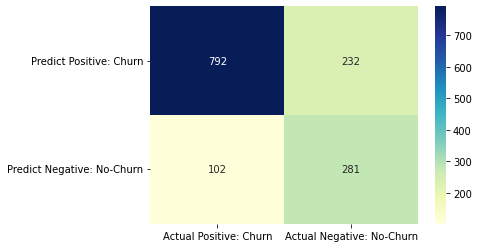


Top 10 important features


,features,importance
0,monthlycharges,617
1,totalcharges,531
2,tenure,250
3,contract_type,49
8,autopay,36
4,gender,35
9,paymentmethod_Mailed check,26
5,paymentmethod_Credit card (automatic),23
6,deviceprotection,17
7,onlinesecurity,16


Least 10 important features


,features,importance
7,onlinesecurity,16
6,deviceprotection,17
5,paymentmethod_Credit card (automatic),23
9,paymentmethod_Mailed check,26
4,gender,35
8,autopay,36
3,contract_type,49
2,tenure,250
1,totalcharges,531
0,monthlycharges,617


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Random Forest with scaling and class_weight balanced on 10 top important features only,0.85,391.806129,0.85,0.79,0.109,0.261996,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,

CPU times: user 4min 25s, sys: 19.2 s, total: 4min 44s
Wall time: 1min 18s


In [52]:
%%time
model = LGBMClassifier(class_weight='balanced',random_state=12345)

params = {                 
            "model__max_depth" : [2, 5, 10],
            "model__num_leaves" : [3, 5, 15, 30, 90],
            "model__n_estimators" : [800, 1000, 1200],
            "model__learning_rate" : [0.3, 0.5, 0.7, 0.8]
         }

columns=['monthlycharges','totalcharges','tenure','contract_type','gender',
         'paymentmethod_Credit card (automatic)', 'deviceprotection', 'onlinesecurity', 'autopay',
         'paymentmethod_Mailed check']
name  ='Light GBM with scaling and class_weight balanced on 10 top important features only'
lgb = train_predict(features_train[columns], target_train, features_test[columns], target_test, params, name, model)
#append the new results 
results = results.append(lgb)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

<a id='winner'></a>
* Training the model again with its top important features only:

### XGBoost Model

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='auc', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=12345, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=2.76, subsample=1,
                               tree_method='exact', validate_parameters=1,
                            

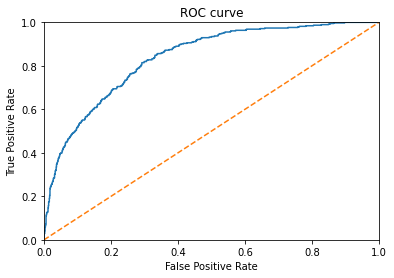


Threshold = 0.10 | accuracy = 0.600 | roc_auc = 0.708 | F1 = 0.562
Threshold = 0.12 | accuracy = 0.610 | roc_auc = 0.714 | F1 = 0.568
Threshold = 0.14 | accuracy = 0.630 | roc_auc = 0.721 | F1 = 0.575
Threshold = 0.16 | accuracy = 0.640 | roc_auc = 0.728 | F1 = 0.582
Threshold = 0.18 | accuracy = 0.650 | roc_auc = 0.730 | F1 = 0.584
Threshold = 0.20 | accuracy = 0.660 | roc_auc = 0.734 | F1 = 0.589
Threshold = 0.22 | accuracy = 0.670 | roc_auc = 0.741 | F1 = 0.597
Threshold = 0.24 | accuracy = 0.680 | roc_auc = 0.746 | F1 = 0.602
Threshold = 0.26 | accuracy = 0.690 | roc_auc = 0.749 | F1 = 0.606
Threshold = 0.28 | accuracy = 0.690 | roc_auc = 0.749 | F1 = 0.607
Threshold = 0.30 | accuracy = 0.700 | roc_auc = 0.753 | F1 = 0.612
Threshold = 0.32 | accuracy = 0.710 | roc_auc = 0.759 | F1 = 0.620
Threshold = 0.34 | accuracy = 0.720 | roc_auc = 0.753 | F1 = 0.616
Threshold = 0.36 | accuracy = 0.730 | roc_auc = 0.757 | F1 = 0.622
Threshold = 0.38 | accuracy = 0.730 | roc_auc = 0.757 | F1 = 

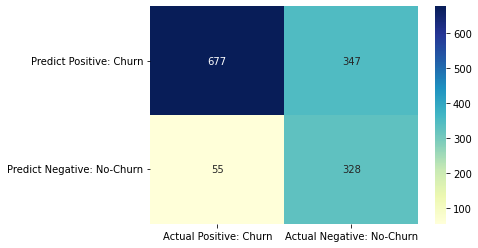


Top 10 important features


,features,importance
21,internetservice_Fiber optic,0.265482
16,contract_type,0.222292
22,internetservice_No,0.153358
12,streamingmovies,0.056042
19,paymentmethod_Electronic check,0.055616
7,onlinesecurity,0.030529
11,streamingtv,0.023751
4,tenure,0.022205
10,techsupport,0.020857
5,phoneservice,0.017057


Least 10 important features


,features,importance
0,gender,0.007708
17,autopay,0.008179
3,dependents,0.008563
20,paymentmethod_Mailed check,0.009351
2,partner,0.009407
8,onlinebackup,0.009904
15,totalcharges,0.010016
18,paymentmethod_Credit card (automatic),0.010070
14,monthlycharges,0.010071
6,multiplelines,0.010763


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Random Forest with scaling and class_weight balanced on 10 top important features only,0.85,391.806129,0.85,0.79,0.109,0.261996,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,

CPU times: user 1h 8min 12s, sys: 20.9 s, total: 1h 8min 33s
Wall time: 17min 51s


In [53]:
%%time
# this step takes about 1 hour

model = XGBClassifier(random_state=12345,scale_pos_weight=2.76,objective='binary:logistic')

params = {  "model__max_depth" : [3, 5, 10],
            "model__n_estimators" : [1000,1200,1350],
            "model__learning_rate" : [0.1,0.3,0.5,0.7],
            'model__eval_metric': ['auc','aucpr']
            }

name  ='XGBoost with scaling with scale_pos_weight'
xgbt = train_predict(features_train, target_train, features_test, target_test, params, name, model)

#append the new results 
results = results.append(xgbt)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

* Training the model again with its top important features only:

Best Model is:  Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='aucpr', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=12345, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=2.76, subsample=1,
                               tree_method='exact', validate_parameters=1,
                          

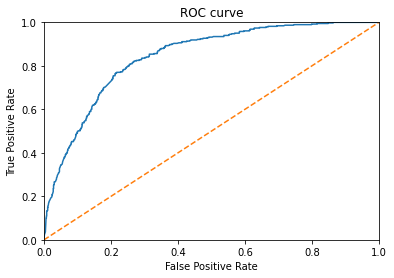


Threshold = 0.10 | accuracy = 0.540 | roc_auc = 0.675 | F1 = 0.534
Threshold = 0.12 | accuracy = 0.560 | roc_auc = 0.685 | F1 = 0.543
Threshold = 0.14 | accuracy = 0.590 | roc_auc = 0.697 | F1 = 0.553
Threshold = 0.16 | accuracy = 0.600 | roc_auc = 0.702 | F1 = 0.558
Threshold = 0.18 | accuracy = 0.610 | roc_auc = 0.710 | F1 = 0.564
Threshold = 0.20 | accuracy = 0.610 | roc_auc = 0.714 | F1 = 0.569
Threshold = 0.22 | accuracy = 0.630 | roc_auc = 0.721 | F1 = 0.575
Threshold = 0.24 | accuracy = 0.640 | roc_auc = 0.729 | F1 = 0.583
Threshold = 0.26 | accuracy = 0.660 | roc_auc = 0.738 | F1 = 0.593
Threshold = 0.28 | accuracy = 0.670 | roc_auc = 0.743 | F1 = 0.598
Threshold = 0.30 | accuracy = 0.680 | roc_auc = 0.749 | F1 = 0.605
Threshold = 0.32 | accuracy = 0.700 | roc_auc = 0.759 | F1 = 0.617
Threshold = 0.34 | accuracy = 0.700 | roc_auc = 0.763 | F1 = 0.622
Threshold = 0.36 | accuracy = 0.710 | roc_auc = 0.762 | F1 = 0.621
Threshold = 0.38 | accuracy = 0.720 | roc_auc = 0.764 | F1 = 

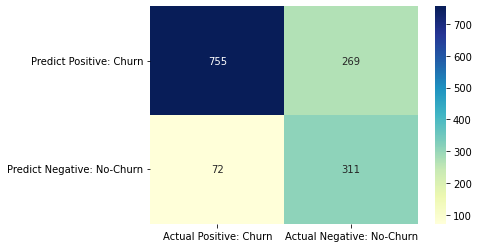


Top 10 important features


,features,importance
1,contract_type,0.432181
0,internetservice_Fiber optic,0.150760
2,internetservice_No,0.096877
4,paymentmethod_Electronic check,0.085819
3,streamingmovies,0.076354
5,tenure,0.045016
6,onlinesecurity,0.044501
8,techsupport,0.036230
7,phoneservice,0.032262
9,onlinesecurity,0.000000


Least 10 important features


,features,importance
9,onlinesecurity,0.000000
7,phoneservice,0.032262
8,techsupport,0.036230
6,onlinesecurity,0.044501
5,tenure,0.045016
3,streamingmovies,0.076354
4,paymentmethod_Electronic check,0.085819
2,internetservice_No,0.096877
0,internetservice_Fiber optic,0.150760
1,contract_type,0.432181


,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time,estimator
0,Decision Tree with scaling,0.83,14.630926,0.83,0.74,0.082,0.021874,"(MinMaxScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853,"(MinMaxScaler(), LogisticRegression(C=0.01, penalty='none', random_state=12345, solver='saga'))"
0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363,"(MinMaxScaler(), LGBMClassifier(max_depth=2, n_estimators=800, num_leaves=3, random_state=12345))"
0,XGBoost with scaling,0.82,1068.368368,0.83,0.74,0.104,0.055068,"(MinMaxScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=1000, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=12345,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None))"
0,Knn with scaling,0.83,33.477617,0.82,0.73,0.105,0.804663,"(MinMaxScaler(), KNeighborsClassifier(n_neighbors=50))"
0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003,"(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced', max_depth=5,\n min_samples_leaf=20, min_samples_split=120,\n random_state=12345))"
0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=1358822685), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=561383553), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=789925284), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_leaf=10, random_state=170765737), DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=4,\n min_samples_l..."
0,Random Forest with scaling and class_weight balanced on 10 top important features only,0.85,391.806129,0.85,0.79,0.109,0.261996,"(MinMaxScaler(), (DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1845187042), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,\n min_samples_leaf=20, random_state=1675701733), DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=2,

CPU times: user 51min 27s, sys: 20.7 s, total: 51min 48s
Wall time: 13min 48s


In [54]:
%%time

model = XGBClassifier(random_state=12345,scale_pos_weight=2.76,objective='binary:logistic')
params = {
            "model__max_depth" : [3, 5, 10],
            "model__n_estimators" : [1000,1200,1350],
            "model__learning_rate" : [0.1,0.3,0.5,0.7],
            'model__eval_metric': ['auc','aucpr']
#             'model__gamma': [0, 0.01, 0.02, 0.03]
         }

name  ='XGBoost with scaling and scale_pos_weight on Top 10 important features only'

columns= ['internetservice_Fiber optic', 'contract_type','internetservice_No','streamingmovies',
          'paymentmethod_Electronic check', 'tenure', 'onlinesecurity', 'phoneservice', 'techsupport',
          'onlinesecurity']

xgbt = train_predict(features_train[columns], target_train, features_test[columns], target_test, params, name, model)

#append the new results 
results = results.append(xgbt)
with pd.option_context('display.max_colwidth', 1000):
    display(results)

### conclusion

* We could see the balance is not really impacting the models the differences are smalls and the only change is for the threshold that we'll take. 
* The demanding of the project was on ROC AUC and accuracy only so in that case the winner is:
* After training all the models with the balanced parameter and on only the top 10 important features we can move on to validate it on the next section.

<a id='section4'></a>
## Sanity check for the model

* Sanity check is when you compare score of your model with the score of the best constant model or any other model.
* For classification task the best constant model is the model which predict the label of the most frequent class.

* So first let find our best constant model:

In [55]:
print(data.columns)
print(round(data.churn.value_counts()/len(data),4))

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'paperlessbilling', 'monthlycharges', 'totalcharges', 'churn',
       'contract_type', 'autopay', 'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'internetservice_Fiber optic', 'internetservice_No'],
      dtype='object')
0    0.7342
1    0.2658
Name: churn, dtype: float64


* Target
  * `Churn` — сustomer has left:
    * Most frequent class is `Non-Churn` = 0 for customers who didnt left the company
    * Churn = 1

**The constant model accuracy score is 0.734**

The baseline roc_auc score: 0.5

Confusion matrix

 [[1024    0]
 [ 383    0]]

True Positives(TP) =  1024

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  383
FNR: 0.272


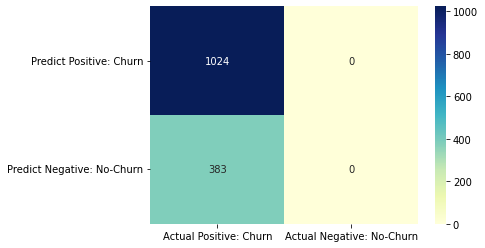

In [56]:
baseline = pd.DataFrame(0, index=np.arange(len(target_test)), columns=['churn'])
print('The baseline roc_auc score:', roc_auc_score(target_test, baseline))

cm = confusion_matrix(target_test,baseline)
print('\nConfusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0]) 

FNR = (cm[1,0]/(cm[1,0]+cm[0,0])).round(3)
print('FNR:', FNR)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive: Churn', 'Actual Negative: No-Churn'], 
                                 index=['Predict Positive: Churn', 'Predict Negative: No-Churn'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show();
print()
    

* roc_auc score for all the models was higher than the baseline roc_auc score: 0.5

### Conclusions


* If the score of the model is worse than the score of best constant model then the model is useless:
  * In our case:
    * The ROC AUC score is 0.85 so our model can be used for predictions.
    * We need to filter the models and to take only the results with accuracy greater than 0.73.
    * All the models got FN less than the baseline.


<a id='section5'></a>
## Overall conclusion

* We need to filter the models and to take only the results with accuracy greater than 0.73 of the baseline:

In [57]:
with pd.option_context('display.max_colwidth', 1000):
    display(results.query('pred_acc_score > 0.73').drop('estimator',axis=1).sort_values(by=['pred_roc_score','pred_acc_score'],ascending=False).reset_index())

,index,Model,fit_score,fit_time,pred_roc_score,pred_acc_score,pred_FNR,predict_time
0,0,Random Forest with scaling and class_weight balanced on 10 top important features only,0.85,391.806129,0.85,0.79,0.109,0.261996
1,0,Logistic Regression with scaling with all features,0.84,31.070193,0.85,0.77,0.100,0.013853
2,0,Logistic Regression with scaling and class_weight balanced on 10 top important features only,0.84,18.334398,0.85,0.76,0.089,0.019198
3,0,Random Forest with scaling,0.85,341.027852,0.85,0.75,0.084,0.287698
4,0,Random Forest with scaling and class_weight balanced on all features,0.85,314.574737,0.85,0.75,0.085,0.147256
5,0,Light GBM with scaling,0.84,65.329204,0.85,0.74,0.082,0.038363
6,0,Decision Tree with scaling and class_weight balanced on all features,0.83,14.453335,0.84,0.77,0.095,0.020003
7,0,XGBoost with scaling and scale_pos_weight on Top 10 important features only,0.83,827.421311,0.84,0.76,0.087,0.053138
8,0,Light GBM with scaling and class_weight balanced on all features,0.83,79.387703,0.84,0.74,0.098,0.040908
9,0,Light GBM with scaling and class_weight balanced on 10 top important features only,0.82,77.496642,0.83,0.76,0.114,0.038645


**First Place**

**Random Forest with scaling and class_weight balanced on 10 top important features only**

**with ROC AUC 0.85 and accuracy of 0.79 on the test and 103 FN.**

Although the Random Forest with scaling but without balance and on all the features had much better FN of 68 which is a difference of 3% of the churn customers which can be missed so my recommendation is to use in this simple way eventhough the accuracy is worse by 4%.